In [ ]:
conda install -c conda-forge pdal

In [5]:
# ===========================================================
# TITLE: Advanced Wireless Sensor Network Gateway Placement
#         (Multi-Objective, Research-Grade, Usability-Enhanced)
# ===========================================================

# 0. ===== Notebook/Script Usage Guide (Markdown) =====
"""
# Advanced WSN Gateway Placement Research Notebook

- **Reproducibility:** All random seeds fixed (RANDOM_SEED=42).
- **Caching:** If you change AOI/DEM, run `memory.clear(warn=False)` to avoid stale cache results.
- **Workflow:** AOI selection → Precompute Candidates → Optimization (MIP/NSGA-III) → Analysis
- **Performance:** Coverage/path loss calculations are cached but slow for large areas—reduce grid/candidates for speed.
"""

# 1. ===== GLOBAL IMPORTS, CONFIG, AND SEEDING =====
import os, random, warnings, json
from typing import List, Tuple, Dict, Optional, Any
from dataclasses import dataclass, field

import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, MultiPoint, Polygon, shape, box
from shapely.ops import unary_union
from geopy.distance import geodesic

import rasterio
from rasterio.io import MemoryFile
from rasterio.mask import mask
from pyproj import Geod

import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain

import pulp
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as cx

from ipyleaflet import Map, DrawControl, basemaps, Marker, GeoJSON, Popup, CircleMarker, Polyline, Circle
from ipywidgets import Button, Output, VBox, HBox, HTML, FloatSlider, IntSlider, Dropdown, Layout, Tab, SelectMultiple

from joblib import Memory
import requests
import pycraf.pathprof as pp
from astropy import units as u

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.termination.default import DefaultMultiObjectiveTermination

import seaborn as sns

import plotly.io as pio
pio.renderers.default = 'vscode'

warnings.filterwarnings('ignore')

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(f"✅ Random seed set: {RANDOM_SEED}")

@dataclass
class NetworkConfig:
    MAX_COMM_RANGE_M: float = 1500.0
    GATEWAY_HEIGHT: float = 5.0
    SENSOR_HEIGHT: float = 5.0

@dataclass
class OptimizationConfig:
    NUM_GATEWAY_CANDIDATES: int = 450
    COVERAGE_GRID_SIZE: int = 35
    TX_POWER_DBM: float = 20.0
    RX_SENSITIVITY_DBM: float = -120.0
    ANTENNA_GAIN_DBI: float = 8.0
    SYSTEM_MARGIN_DB: float = 8.0

    @property
    def MAX_ALLOWABLE_PATH_LOSS_DB(self) -> float:
        return (self.TX_POWER_DBM + self.ANTENNA_GAIN_DBI * 2 -
                self.RX_SENSITIVITY_DBM - self.SYSTEM_MARGIN_DB)

NETWORK = NetworkConfig()
OPTIMIZATION = OptimizationConfig()
cachedir = './.wsn_cache'
memory = Memory(cachedir, verbose=0)
def clear_all_cache_dirs():
    import shutil
    cache_dirs = [
        './.sensor_cache', './.joblib_cache', './.wsn_cache',
        './.phase1_cache', './.phase2_cache', './.dem_cache', './.cache',
        './output_cache', './.ipynb_checkpoints', './.pymoo_cache',
        './.tmp_cache', './.memory_cache'
    ]
    for d in cache_dirs:
        try:
            shutil.rmtree(d)
            print(f"🧹 Cleared {d} directory.")
        except FileNotFoundError:
            pass
        except Exception as e:
            print(f"⚠️ Could not clear {d}: {e}")
    print("✅ All listed cache folders cleared (if they existed).")

clear_all_cache_dirs()

try:
    memory.clear(warn=False)
    print("✅ Cleared joblib.Memory cache successfully.")
except Exception as e:
    print("⚠️ Cache clear failed or not needed:", e)

# State containers: global only for notebook—avoid overwriting!
dem_manager = None
aoi_poly: Optional[Polygon] = None
drawn_geometry: Dict[str, Any] = {}
gateway_candidate_df: Optional[pd.DataFrame] = None
saved_solutions = {}
solution_counter = 0

print("✅ All libraries, configs, and globals loaded.")

✅ Random seed set: 42
🧹 Cleared ./.wsn_cache directory.
✅ All listed cache folders cleared (if they existed).
⚠️ Cache clear failed or not needed: [Errno 2] No such file or directory: './.wsn_cache/joblib'
✅ All libraries, configs, and globals loaded.


In [7]:
# 2. ===== DEM HANDLING & CORE UTILITIES =====

class DEMManager:
    """
    Centralized manager for DEM data. Computes slope/aspect, provides elevation/terrain profile utilities.
    """
    def __init__(self, dem_bytes: bytes):
        with MemoryFile(dem_bytes) as memfile:
            with memfile.open() as src:
                self.dem_array = src.read(1)
                self.transform = src.transform
                self.bounds = src.bounds
                self.profile = src.profile
                self.crs = src.crs
        self.shape = self.dem_array.shape
        self.slope_arr = None
        self.aspect_arr = None
        # DEM pixel size check
        pixel_width = abs(self.transform.a)
        pixel_height = abs(self.transform.e)
        print(f"DEM pixel width: {pixel_width}, pixel height: {pixel_height}")
        if pixel_width < 1e-6 or pixel_height < 1e-6:
            raise ValueError("Invalid DEM: pixel size too small.")

    def degree_to_meter(self, lon, lat):
        geod = Geod(ellps='WGS84')
        dx = abs(self.transform.a)
        dy = abs(self.transform.e)
        _, _, x_meter = geod.inv(lon, lat, lon + dx, lat)
        _, _, y_meter = geod.inv(lon, lat, lon, lat + dy)
        return abs(x_meter), abs(y_meter)

    def calculate_slope_and_aspect(self):
        center_col = self.dem_array.shape[1] // 2
        center_row = self.dem_array.shape[0] // 2
        lon0, lat0 = self.transform * (center_col, center_row)
        dx_meter, dy_meter = self.degree_to_meter(lon0, lat0)
        gy, gx = np.gradient(self.dem_array.astype(float), dy_meter, dx_meter)
        self.slope_arr = np.degrees(np.arctan(np.sqrt(gx**2 + gy**2)))
        aspect_rad = np.arctan2(-gx, gy)
        self.aspect_arr = np.degrees(aspect_rad)
        self.aspect_arr[self.aspect_arr < 0] += 360

    def get_elevation(self, coord: Tuple[float, float]) -> float:
        col, row = ~self.transform * coord
        row, col = int(row), int(col)
        if 0 <= row < self.shape[0] and 0 <= col < self.shape[1]:
            return float(self.dem_array[row, col])
        return 0.0

    def get_terrain_profile(self, p1: Tuple[float, float], p2: Tuple[float, float], num_samples: int = 100) -> Tuple[np.ndarray, np.ndarray]:
        lons = np.linspace(p1[0], p2[0], num_samples)
        lats = np.linspace(p1[1], p2[1], num_samples)
        elevs = np.array([self.get_elevation((lon, lat)) for lon, lat in zip(lons, lats)])
        dist_m = geodesic(p1[::-1], p2[::-1]).meters
        dists = np.linspace(0, dist_m, num_samples)
        return dists, elevs

# --- Sampling, Grid, Path Loss, Solar Utilities (with cache note) ---

def sample_points_in_poly(polygon: Polygon, n_points: int) -> List[Tuple[float, float]]:
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < n_points:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(p):
            points.append((p.x, p.y))
    return points

def generate_coverage_grid(polygon: Polygon, grid_size: int) -> List[Tuple[float, float]]:
    min_x, min_y, max_x, max_y = polygon.bounds
    x_coords, y_coords = np.linspace(min_x, max_x, grid_size), np.linspace(min_y, max_y, grid_size)
    grid_points = [Point(x, y) for x in x_coords for y in y_coords if polygon.contains(Point(x, y))]
    return [(p.x, p.y) for p in grid_points]

# --- Utility: Consistent Gateway Sorting for Plotting ---
def sort_gateways(solution, sort_by="lon"):
    """
    Sorts gateways for consistent labeling in plots.
    Args:
        solution (list): List of gateway dicts, each with 'coord' key (lon, lat)
        sort_by (str): Sorting method: 'lon', 'lat', or 'centroid'
    Returns:
        Sorted list of gateway dicts
    """
    if not solution or not isinstance(solution, list) or 'coord' not in solution[0]:
        return solution
    if sort_by == "lon":
        return sorted(solution, key=lambda gw: gw['coord'][0])   # West to East
    elif sort_by == "lat":
        return sorted(solution, key=lambda gw: gw['coord'][1])   # South to North
    elif sort_by == "centroid":
        if 'aoi_poly' in globals() and aoi_poly is not None:
            from shapely.geometry import Point
            centroid = aoi_poly.centroid
            return sorted(solution, key=lambda gw: Point(gw['coord']).distance(centroid))
        else:
            return solution
    else:
        return solution
    


@memory.cache
def calculate_solar_score(
    coord: Tuple[float, float],
    dem_manager: DEMManager,
    panel_power_watts: float = 50,
    gamma_pdc: float = -0.004,
    inverter_power_watts: float = 50,
    temp_air: float = 20.0,
    wind_speed: float = 1.0
) -> float:
    col, row = ~dem_manager.transform * coord
    row, col = int(row), int(col)
    if not (0 <= row < dem_manager.shape[0] and 0 <= col < dem_manager.shape[1]):
        return 0.0
    tilt = float(np.clip(dem_manager.slope_arr[row, col], 0, 90)) if dem_manager.slope_arr is not None else 30.0
    azimuth = float(dem_manager.aspect_arr[row, col] % 360) if dem_manager.aspect_arr is not None else 180.0
    altitude = float(dem_manager.dem_array[row, col])
    lon, lat = coord
    loc = Location(lat, lon, tz='UTC', altitude=altitude)
    times = pd.date_range('2025-06-21', periods=24, freq='H', tz=loc.tz)
    weather = loc.get_clearsky(times, model='ineichen')
    weather['temp_air'] = temp_air
    weather['wind_speed'] = wind_speed
    system = PVSystem(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        module_parameters={'pdc0': panel_power_watts, 'gamma_pdc': gamma_pdc},
        inverter_parameters={'pdc0': inverter_power_watts},
        temperature_model_parameters={'a': -3.56, 'b': 0.0594, 'deltaT': 3}
    )
    mc = ModelChain(system, loc, dc_model='pvwatts', ac_model='pvwatts', aoi_model='physical',
                    spectral_model='no_loss', temperature_model='sapm', losses_model='no_loss')
    mc.run_model(weather)
    return float(mc.results.ac.sum()) / 1000.0 if hasattr(mc.results, 'ac') else 0.0

print("✅ DEMManager and utilities loaded.")

✅ DEMManager and utilities loaded.


In [8]:
# 3. ===== AOI SELECTION INTERFACE (USABILITY) =====

def fix_aoi_bounds(aoi_poly, dem_manager):
    aoi_bounds, dem_bounds = aoi_poly.bounds, dem_manager.bounds
    if (aoi_bounds[0] < dem_bounds[0] or aoi_bounds[1] < dem_bounds[1] or 
        aoi_bounds[2] > dem_bounds[2] or aoi_bounds[3] > dem_bounds[3]):
        safe_bounds = (
            max(aoi_bounds[0], dem_bounds[0] + 0.0001),
            max(aoi_bounds[1], dem_bounds[1] + 0.0001),
            min(aoi_bounds[2], dem_bounds[2] - 0.0001),
            min(aoi_bounds[3], dem_bounds[3] - 0.0001)
        )
        trimmed_poly = box(*safe_bounds)
        print(f"   Area lost: {100 * (aoi_poly.area - trimmed_poly.area) / aoi_poly.area:.2f}%")
        return trimmed_poly
    return aoi_poly

def create_aoi_selection_interface(center: Tuple[float, float] = (34.2, -118.16)):
    global drawn_geometry, aoi_poly, dem_manager, gateway_candidate_df
    m = Map(center=center, zoom=13, basemap=basemaps.Esri.WorldImagery)
    draw_control = DrawControl(
        circle={'shapeOptions': {'color': '#6bc2e5', 'weight': 3}},
        rectangle={'shapeOptions': {'color': '#fca45d', 'weight': 3}},
        polygon={'shapeOptions': {'color': '#4bc44b', 'weight': 3}}
    )
    output = Output()

    def handle_draw(self, action, geo_json):
        output.clear_output()
        global drawn_geometry
        with output:
            print(f"✓ Shape drawn: {action}")
            print(f"  Type: {geo_json['geometry']['type']}")
            drawn_geometry = geo_json

    draw_control.on_draw(handle_draw)
    m.add_control(draw_control)

    btn = Button(description='Complete Selection', button_style='success')
    ui = VBox([m, btn, output])

    def on_complete_clicked(b):
        global aoi_poly, dem_manager, drawn_geometry
        with output:
            output.clear_output()
            print("=" * 50)
            print("PROCESSING AOI SELECTION")
            print("=" * 50)
            if not drawn_geometry:
                print("❌ ERROR: No area selected. Please draw a shape on the map.")
                return
            try:
                aoi_poly = shape(drawn_geometry['geometry'])
                bounds = aoi_poly.bounds
                print(f"✓ AOI bounds: {bounds}")
                minx, miny, maxx, maxy = bounds
                api_key = os.environ.get('OPENTOPO_API_KEY', '50a0cd794b0c3c7d0809733e4498ffef')
                url = "https://portal.opentopography.org/API/globaldem"
                params = {
                    "demtype": "SRTMGL1", "south": miny, "north": maxy, "west": minx, "east": maxx,
                    "outputFormat": "GTiff", "API_Key": api_key
                }
                print("\n📡 Requesting DEM data from OpenTopography...")
                response = requests.get(url, params=params, timeout=30)
                if response.status_code == 200:
                    print(f"✓ DEM data received: {len(response.content) / 1024:.1f} KB")
                    dem_manager = DEMManager(response.content)
                    # ---- EXTENDED DEBUGGING ----
                    print("\n--- DEM Debug Info ---")
                    print("DEM CRS:", dem_manager.crs)
                    print("DEM transform:", dem_manager.transform)
                    print("DEM bounds:", dem_manager.bounds)
                    print("DEM shape:", dem_manager.shape)
                    pixel_width = abs(dem_manager.transform.a)
                    pixel_height = abs(dem_manager.transform.e)
                    print(f"DEM pixel width: {pixel_width}, pixel height: {pixel_height}")
                    print(f"DEM min/max/mean elevation: {np.min(dem_manager.dem_array):.2f} / {np.max(dem_manager.dem_array):.2f} / {np.mean(dem_manager.dem_array):.2f}")

                    dem_manager.calculate_slope_and_aspect()
                    if dem_manager.slope_arr is not None and np.isfinite(dem_manager.slope_arr).any():
                        print("Slope array min/max/mean:", 
                            np.nanmin(dem_manager.slope_arr),
                            np.nanmax(dem_manager.slope_arr),
                            np.nanmean(dem_manager.slope_arr))
                    else:
                        print("Slope array is empty or contains only NaN values.")
                    print("--- End DEM Debug ---\n")
                    aoi_poly = fix_aoi_bounds(aoi_poly, dem_manager)
                else:
                    print(f"❌ ERROR: DEM request failed (HTTP {response.status_code})")
                    print(f"  Response: {response.text[:200]}...")
            except Exception as e:
                print(f"❌ ERROR: {type(e).__name__}: {str(e)}")
                import traceback
                traceback.print_exc()
        print("👉 AOI and DEM loaded. Please run the next cell ('Gateway Candidate Precomputation').")

    btn.on_click(on_complete_clicked)
    return ui

aoi_interface = create_aoi_selection_interface()
display(aoi_interface)

In [9]:
import pyproj
from shapely.ops import transform as shapely_transform
import rasterio
import numpy as np
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import mapping

def reproject_aoi_to_raster(aoi_poly, raster_crs):
    project = pyproj.Transformer.from_crs("EPSG:4326", raster_crs, always_xy=True).transform
    aoi_proj = shapely_transform(project, aoi_poly)
    return aoi_proj

# --- Load and Mask LiDAR to AOI ---
lidar_tif = "2025_LA_response_Altadena_USGS1m.tif"
with rasterio.open(lidar_tif) as src:
    lidar_crs = src.crs
    if aoi_poly is not None:
        aoi_proj = reproject_aoi_to_raster(aoi_poly, lidar_crs)
        out_image, out_transform = mask(src, [mapping(aoi_proj)], crop=True)
        lidar_data = out_image[0]
        lidar_transform = out_transform
        nodata = src.nodata if src.nodata is not None else -999999.0
        print("✅ Masked LiDAR to AOI bounds.")
    else:
        lidar_data = src.read(1)
        lidar_transform = src.transform
        nodata = src.nodata if src.nodata is not None else -999999.0
        print("⚠️ AOI not set, showing full raster.")

# Mask nodata for display
lidar_masked = np.where((lidar_data == nodata) | (lidar_data < -1000), np.nan, lidar_data)
# --- Compute Slope and Aspect from DSM (add these lines!) ---
dy, dx = abs(lidar_transform.e), abs(lidar_transform.a)
gy, gx = np.gradient(lidar_masked.astype(float), dy, dx)
slope = np.degrees(np.arctan(np.sqrt(gx**2 + gy**2)))
aspect = np.degrees(np.arctan2(-gx, gy))
aspect[aspect < 0] += 360

# --- Compute Canopy Height Model (CHM) ---
dem_resampled = np.empty_like(lidar_data, dtype=float)
reproject(
    dem_manager.dem_array,
    dem_resampled,
    src_transform=dem_manager.transform,
    src_crs=dem_manager.crs,
    dst_transform=lidar_transform,
    dst_crs=lidar_crs,
    resampling=Resampling.bilinear
)
chm = lidar_data - dem_resampled
chm[chm < 0] = 0
chm_transform = lidar_transform  # Always matches the CHM's affine!

✅ Masked LiDAR to AOI bounds.


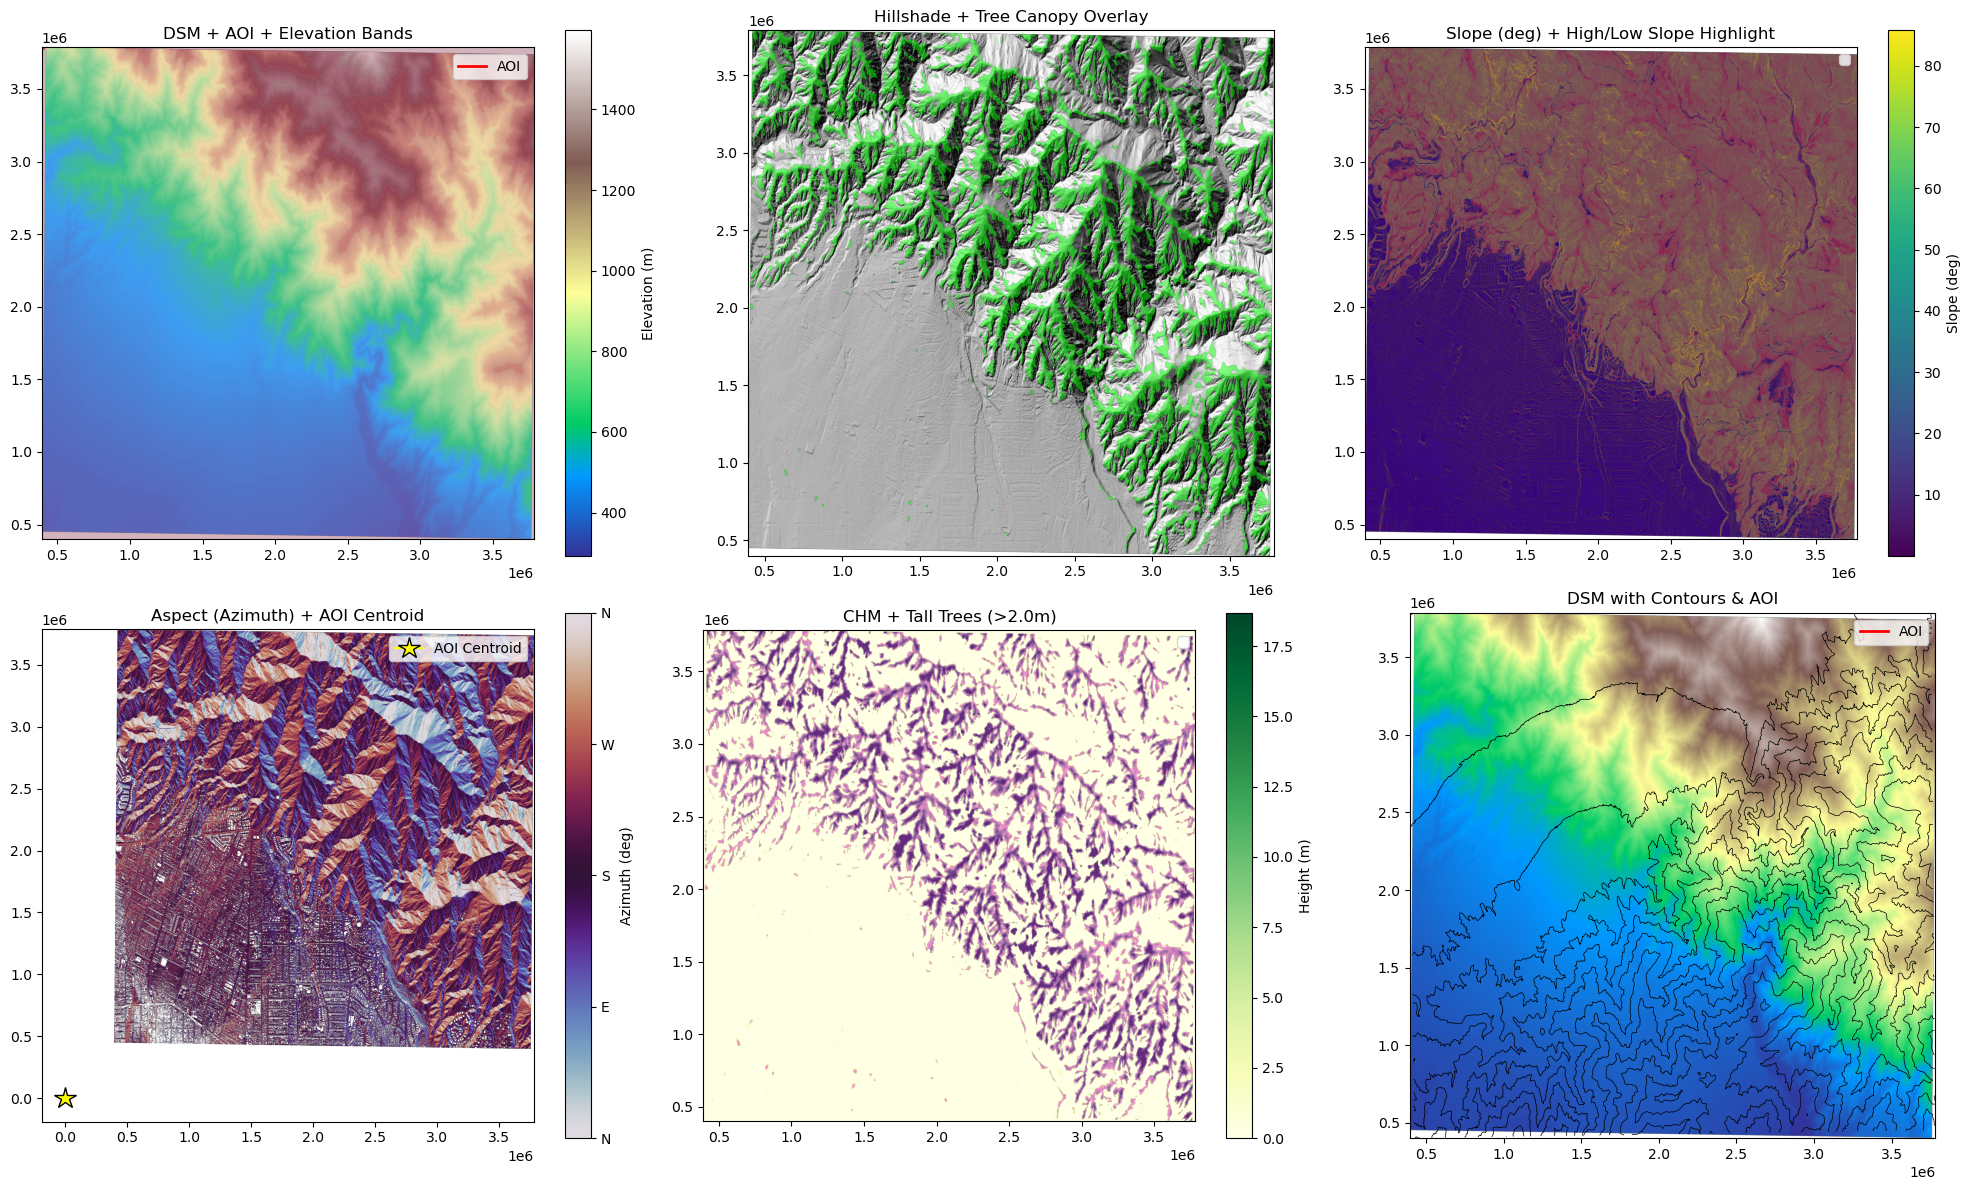

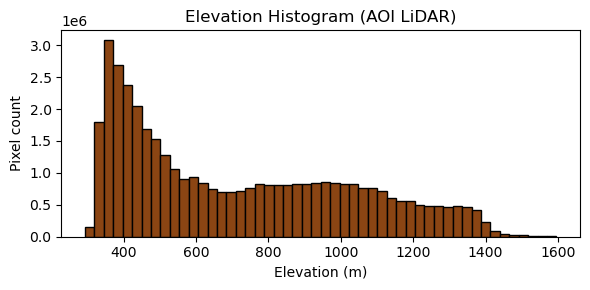

In [11]:
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.colors import LightSource, ListedColormap, BoundaryNorm
import numpy as np
import rasterio

# -----------------
# Feature Parameters
# -----------------
CHM_TREE_HEIGHT = 2.0  # meters, threshold for tall vegetation
HIGH_SLOPE = 10        # degrees
LOW_SLOPE = 5          # degrees
ELEVATION_BANDS = [900, 1000, 1100, 1200, 1300, 1400]  # example
# Optional: Provide a few gateway/sensor coords in AOI for illustration
example_coords = [(aoi_poly.centroid.x, aoi_poly.centroid.y)] if 'aoi_poly' in globals() and aoi_poly is not None else []

# --------------------
# Compute Extra Masks
# --------------------
# Tree/canopy mask from CHM
tree_mask = (chm > CHM_TREE_HEIGHT) if ('chm' in globals() and chm is not None) else np.zeros_like(lidar_masked, dtype=bool)
# High/low slope masks
high_slope_mask = (slope > HIGH_SLOPE)
low_slope_mask = (slope < LOW_SLOPE)
# Elevation bands mask
elev_band_mask = np.digitize(lidar_masked, ELEVATION_BANDS)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. DSM with AOI and elevation bands
im0 = axes[0, 0].imshow(lidar_masked, cmap='terrain', extent=rasterio.transform.array_bounds(*lidar_masked.shape, lidar_transform))
axes[0, 0].set_title("DSM + AOI + Elevation Bands")
plt.colorbar(im0, ax=axes[0, 0], label="Elevation (m)")
# Overlay AOI
if 'aoi_poly' in globals() and aoi_poly is not None:
    from shapely.ops import transform as shapely_transform
    import pyproj
    project = pyproj.Transformer.from_crs("EPSG:4326", lidar_crs, always_xy=True).transform
    aoi_proj = shapely_transform(project, aoi_poly)
    x, y = aoi_proj.exterior.xy
    axes[0, 0].plot(x, y, color='red', linewidth=2, label='AOI')
    axes[0, 0].legend()
# Overlay elevation bands
band_cmap = ListedColormap(plt.cm.PuRd(np.linspace(0.3, 1, len(ELEVATION_BANDS)+1)))
im0b = axes[0, 0].imshow(elev_band_mask, cmap=band_cmap, alpha=0.3, extent=rasterio.transform.array_bounds(*lidar_masked.shape, lidar_transform))

# 2. Hillshade with tree/canopy overlay
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(lidar_masked, vert_exag=1, dx=1, dy=1)
im1 = axes[0, 1].imshow(hillshade, cmap='gray', extent=rasterio.transform.array_bounds(*lidar_masked.shape, lidar_transform))
axes[0, 1].set_title("Hillshade + Tree Canopy Overlay")
# Overlay trees
if np.any(tree_mask):
    axes[0, 1].imshow(np.ma.masked_where(~tree_mask, tree_mask), cmap=ListedColormap(['lime']), alpha=0.5,
                      extent=rasterio.transform.array_bounds(*tree_mask.shape, lidar_transform), label='Tall Canopy')
axes[0, 1].legend(['Tree Canopy'])

# 3. Slope with high/low slope overlay
im2 = axes[0, 2].imshow(slope, cmap='viridis', extent=rasterio.transform.array_bounds(*lidar_masked.shape, lidar_transform))
axes[0, 2].set_title("Slope (deg) + High/Low Slope Highlight")
plt.colorbar(im2, ax=axes[0, 2], label="Slope (deg)")
# Overlay high/low slope
axes[0, 2].imshow(np.ma.masked_where(~high_slope_mask, high_slope_mask), cmap=ListedColormap(['red']), alpha=0.4, extent=rasterio.transform.array_bounds(*high_slope_mask.shape, lidar_transform))
axes[0, 2].imshow(np.ma.masked_where(~low_slope_mask, low_slope_mask), cmap=ListedColormap(['blue']), alpha=0.2, extent=rasterio.transform.array_bounds(*low_slope_mask.shape, lidar_transform))
axes[0, 2].legend(['High Slope', 'Low Slope'])

# 4. Aspect with centroid overlay
aspect_masked = np.where(slope > 2, aspect, np.nan)
im3 = axes[1, 0].imshow(aspect_masked, cmap='twilight', vmin=0, vmax=360, extent=rasterio.transform.array_bounds(*lidar_masked.shape, lidar_transform))
axes[1, 0].set_title("Aspect (Azimuth) + AOI Centroid")
cb3 = plt.colorbar(im3, ax=axes[1, 0], label="Azimuth (deg)")
cb3.set_ticks([0, 90, 180, 270, 360])
cb3.set_ticklabels(['N', 'E', 'S', 'W', 'N'])
# Overlay AOI centroid and gateway/sensor spots
if len(example_coords) > 0:
    for c in example_coords:
        axes[1, 0].plot(c[0], c[1], marker='*', color='yellow', markersize=16, markeredgecolor='k', label='AOI Centroid')
    axes[1, 0].legend(['AOI Centroid'])

# 5. CHM (Canopy Height Model) with high canopy >X m
if 'chm' in globals() and chm is not None:
    vmax = np.percentile(chm[~np.isnan(chm)], 98) if np.any(~np.isnan(chm)) else 10
    im4 = axes[1, 1].imshow(chm, cmap='YlGn', vmin=0, vmax=vmax, extent=rasterio.transform.array_bounds(*chm.shape, lidar_transform))
    axes[1, 1].set_title("CHM + Tall Trees (>{}m)".format(CHM_TREE_HEIGHT))
    plt.colorbar(im4, ax=axes[1, 1], label="Height (m)")
    # Overlay only tree tops
    axes[1, 1].imshow(np.ma.masked_where(~tree_mask, tree_mask), cmap=ListedColormap(['magenta']), alpha=0.4,
                      extent=rasterio.transform.array_bounds(*tree_mask.shape, lidar_transform))
    axes[1, 1].legend(['Tall Canopy'])
else:
    axes[1, 1].axis('off')

# 6. DSM with AOI outline and contours (for context)
contour_levels = np.linspace(np.nanmin(lidar_masked), np.nanmax(lidar_masked), 15)
axes[1, 2].imshow(lidar_masked, cmap='terrain', extent=rasterio.transform.array_bounds(*lidar_masked.shape, lidar_transform))
cs = axes[1, 2].contour(lidar_masked, levels=contour_levels, colors='k', linewidths=0.5, extent=rasterio.transform.array_bounds(*lidar_masked.shape, lidar_transform))
axes[1, 2].set_title("DSM with Contours & AOI")
if 'aoi_poly' in globals() and aoi_poly is not None:
    axes[1, 2].plot(x, y, color='red', linewidth=2)
axes[1, 2].legend(['AOI'])

plt.tight_layout()
plt.show()

# --- Histogram for elevation values in AOI ---
plt.figure(figsize=(6, 3))
plt.hist(lidar_masked[~np.isnan(lidar_masked)].ravel(), bins=50, color='saddlebrown', edgecolor='black')
plt.title("Elevation Histogram (AOI LiDAR)")
plt.xlabel("Elevation (m)")
plt.ylabel("Pixel count")
plt.tight_layout()
plt.show()

In [21]:
with rasterio.open(lidar_tif) as src:
    print(src.meta)
    print(src.descriptions)
    print(src.tags())

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -999999.0, 'width': 23539, 'height': 17665, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26911"]]'), 'transform': Affine(1.0, 0.0, 388363.0,
       0.0, -1.0, 3793875.0)}
(None,)
{'AREA_OR_POINT': 'Area'}



⏳ Starting enhanced pre-computation with 1000 candidates...
Filtered 353/1000 candidates as human-accessible.
Generating coverage grid...
Calculating coverage for all candidates (parallelized)...
    Processed candidate 353/353
✅ Enhanced pre-computation complete!

📊 Objective Statistics:
  Coverage: 44.81 - 99.72 (mean: 73.50)
  Solar: 0.33 - 0.37 (mean: 0.34)
  Elevation: 345.00 - 1422.00 (mean: 670.05)
  Accessibility: 0.78 - 0.96 (mean: 0.90)
  Installation_cost: 0.76 - 0.94 (mean: 0.89)
  Terrain_suitability: 0.80 - 1.00 (mean: 0.93)
  Valley_coverage: 0.55 - 0.92 (mean: 0.81)
✅ Candidate objective table computed. Please proceed to the Gateway Optimization cell.
🔽 Candidate DataFrame exported to gateway_candidates.csv


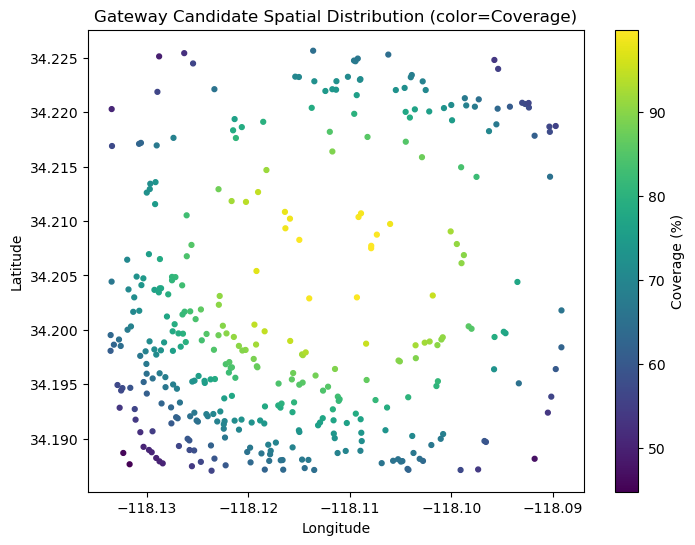

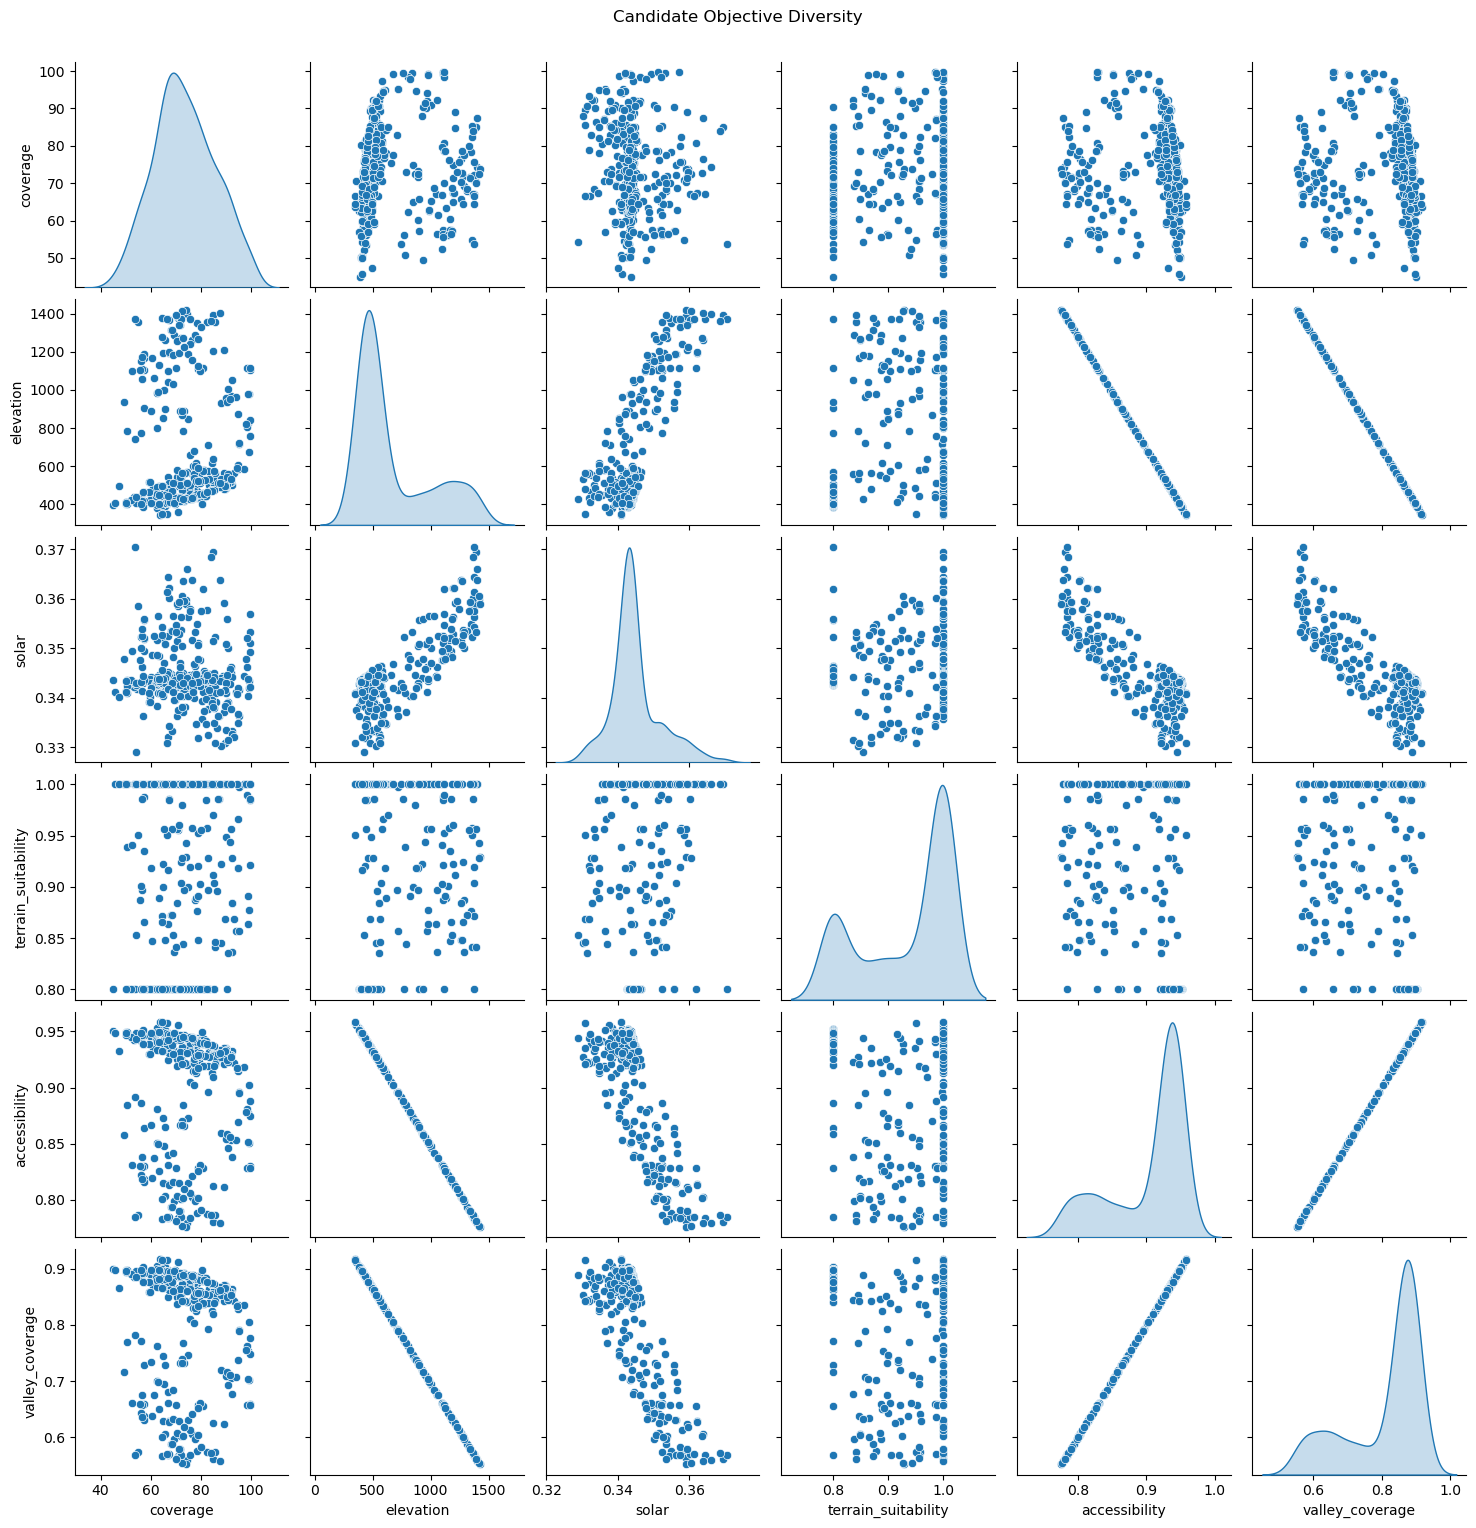

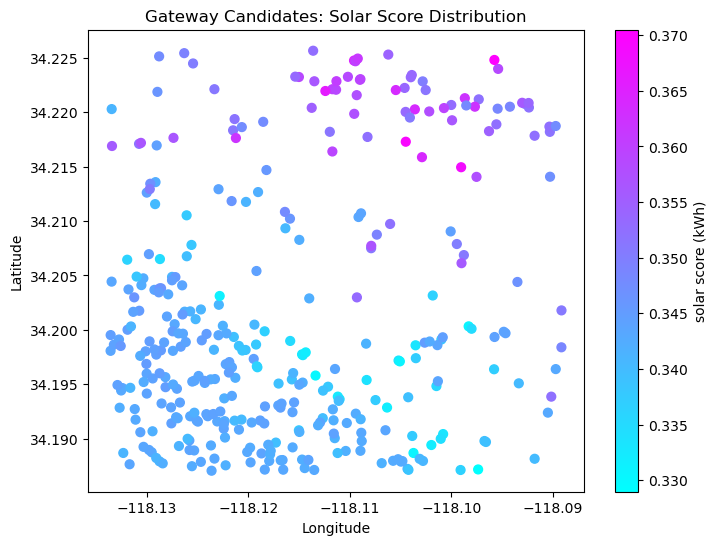

In [10]:
# 5. ===== GATEWAY CANDIDATE PRECOMPUTATION (Parallel-Safe, Primitive Args) =====

import pandas as pd
import numpy as np
from geopy.distance import geodesic
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

def normalize_df_columns(df, cols):
    for col in cols:
        if col in df.columns:
            vals = df[col].values
            min_val = np.nanmin(vals)
            max_val = np.nanmax(vals)
            if max_val > min_val:
                df[f"{col}_norm"] = (vals - min_val) / (max_val - min_val)
            else:
                df[f"{col}_norm"] = np.zeros_like(vals)
    return df

def get_elevation(coord, dem_array, dem_transform):
    col, row = ~dem_transform * coord
    row, col = int(row), int(col)
    if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
        return float(dem_array[row, col])
    return 0.0

def get_slope(coord, slope_arr, dem_transform):
    col, row = ~dem_transform * coord
    row, col = int(row), int(col)
    if slope_arr is not None and 0 <= row < slope_arr.shape[0] and 0 <= col < slope_arr.shape[1]:
        return float(slope_arr[row, col])
    return 15.0

def calculate_enhanced_objectives(coord, dem_array, dem_transform, slope_arr) -> dict:
    elevation = get_elevation(coord, dem_array, dem_transform)
    max_elevation, min_elevation = 6000.0, 100.0
    accessibility = 1.0 - ((elevation - min_elevation) / (max_elevation - min_elevation))
    accessibility = max(0.1, min(1.0, accessibility))
    base_cost, elevation_cost_factor = 1000.0, 0.002
    installation_cost = base_cost * (1 + elevation_cost_factor * elevation)
    max_cost = base_cost * (1 + elevation_cost_factor * max_elevation)
    cost_score = 1.0 - ((installation_cost - base_cost) / (max_cost - base_cost))
    slope = get_slope(coord, slope_arr, dem_transform)
    if 5 <= slope <= 15:
        terrain_score = 1.0
    elif slope < 5:
        terrain_score = 0.8
    elif slope <= 30:
        terrain_score = 1.0 - ((slope - 15) / 15) * 0.5
    else:
        terrain_score = 0.3
    center_elevation = (max_elevation + min_elevation) / 2
    valley_bonus = (
        1.0 - ((elevation - min_elevation) / (center_elevation - min_elevation))
        if elevation < center_elevation else 0.5
    )
    return {
        'accessibility': accessibility,
        'installation_cost': cost_score,
        'terrain_suitability': terrain_score,
        'valley_coverage': valley_bonus
    }

def filter_candidates_by_criteria(
    candidates, dem_array, dem_transform, slope_arr, min_elev=200, max_elev=1800, max_slope=20
):
    filtered = []
    for coord in candidates:
        elev = get_elevation(coord, dem_array, dem_transform)
        slope = get_slope(coord, slope_arr, dem_transform)
        if min_elev <= elev <= max_elev and slope <= max_slope:
            filtered.append(coord)
    print(f"Filtered {len(filtered)}/{len(candidates)} candidates as human-accessible.")
    return filtered

def get_path_loss_with_veg(
    p1, p2, dem_array, dem_transform, chm, chm_transform,
    tx_h, rx_h, freq_mhz, veg_threshold, attn_per_meter, max_comm_range
):
    from geopy.distance import geodesic
    dist_m = geodesic(p1[::-1], p2[::-1]).meters
    if dist_m > max_comm_range:
        return float('inf')
    dist_km = dist_m / 1000.0
    if dist_km <= 0: return 0.0
    fspl_db = 20 * np.log10(dist_km) + 20 * np.log10(freq_mhz) + 32.45
    antenna_height_correction = -10 * np.log10(tx_h * rx_h) if tx_h > 0 and rx_h > 0 else 0.0

    # Terrain penalty
    col1, row1 = ~dem_transform * p1
    row1, col1 = int(row1), int(col1)
    col2, row2 = ~dem_transform * p2
    row2, col2 = int(row2), int(col2)
    elev1 = dem_array[row1, col1] if (0 <= row1 < dem_array.shape[0] and 0 <= col1 < dem_array.shape[1]) else 0.0
    elev2 = dem_array[row2, col2] if (0 <= row2 < dem_array.shape[0] and 0 <= col2 < dem_array.shape[1]) else 0.0
    elev_diff = abs(elev1 - elev2)
    terrain_penalty = (elev_diff / 100.0) * 5.0

    # Veg attenuation
    num_samples = int(dist_m // 5) + 2
    lons = np.linspace(p1[0], p2[0], num_samples)
    lats = np.linspace(p1[1], p2[1], num_samples)
    veg_attn = 0.0
    for lon, lat in zip(lons, lats):
        col, row = ~chm_transform * (lon, lat)
        row, col = int(row), int(col)
        if 0 <= row < chm.shape[0] and 0 <= col < chm.shape[1]:
            canopy_h = chm[row, col]
            if canopy_h > veg_threshold:
                veg_attn += attn_per_meter * 5.0
    return fspl_db + terrain_penalty + antenna_height_correction + veg_attn

def coverage_score_for_candidate(
    coord, coverage_grid, dem_array, dem_transform, chm, chm_transform,
    tx_h, rx_h, freq_mhz, veg_threshold, attn_per_meter, max_comm_range, max_path_loss_db
):
    return (
        sum(
            1 for p in coverage_grid
            if get_path_loss_with_veg(
                coord, p, dem_array, dem_transform, chm, chm_transform,
                tx_h, rx_h, freq_mhz, veg_threshold, attn_per_meter, max_comm_range
            ) <= max_path_loss_db
        ) / len(coverage_grid) * 100 if coverage_grid else 0.0
    )

def precompute_gateway_objectives_enhanced(
    aoi_poly, dem_manager, chm, chm_transform,
    tx_h, rx_h, freq_mhz, veg_threshold, attn_per_meter, max_comm_range, max_path_loss_db,
    num_candidates=4000, export_csv=True, csv_path="gateway_candidates.csv"
) -> pd.DataFrame:
    print("\n⏳ Starting enhanced pre-computation with", num_candidates, "candidates...")
    dem_array = dem_manager.dem_array
    dem_transform = dem_manager.transform
    slope_arr = dem_manager.slope_arr

    candidates = sample_points_in_poly(aoi_poly, num_candidates)
    candidates = filter_candidates_by_criteria(candidates, dem_array, dem_transform, slope_arr)
    print("Generating coverage grid...")
    coverage_grid = generate_coverage_grid(aoi_poly, 35)  # Replace with your OPTIMIZATION.COVERAGE_GRID_SIZE if not fixed
    aoi_centroid = (aoi_poly.centroid.x, aoi_poly.centroid.y)
    distances_to_center = [geodesic(c[::-1], aoi_centroid[::-1]).meters for c in candidates]
    max_dist_from_center = max(distances_to_center) if distances_to_center else 1.0

    print("Calculating coverage for all candidates (parallelized)...")
    coverage_scores = Parallel(n_jobs=-1, prefer="processes")(
        delayed(coverage_score_for_candidate)(
            coord, coverage_grid, dem_array, dem_transform, chm, chm_transform,
            tx_h, rx_h, freq_mhz, veg_threshold, attn_per_meter, max_comm_range, max_path_loss_db
        ) for coord in candidates
    )

    objective_data = []
    for i, coord in enumerate(candidates):
        elevation = get_elevation(coord, dem_array, dem_transform)
        # NOTE: Keep solar_score/calculate_solar_score as before (should be parallelized too if slow)
        solar_score = calculate_solar_score(coord, dem_manager)
        coverage_score = coverage_scores[i]
        centrality_score = 1 - (distances_to_center[i] / max_dist_from_center)
        enhanced_obj = calculate_enhanced_objectives(coord, dem_array, dem_transform, slope_arr)
        objective_data.append({
            'candidate_index': i,
            'coord': coord,
            'lon': coord[0], 'lat': coord[1],
            'elevation': elevation,
            'solar': solar_score,
            'coverage': coverage_score,
            'centrality': centrality_score,
            **enhanced_obj
        })
        if (i+1) % 100 == 0 or (i+1) == len(candidates):
            print(f"\r    Processed candidate {i+1}/{len(candidates)}", end="")
    print("\n✅ Enhanced pre-computation complete!")

    df = pd.DataFrame(objective_data)
    gateway_objectives = [
        'coverage', 'solar', 'elevation', 'accessibility',
        'installation_cost', 'terrain_suitability', 'valley_coverage', 'centrality'
    ]
    df = normalize_df_columns(df, gateway_objectives)

    print("\n📊 Objective Statistics:")
    for obj in ['coverage', 'solar', 'elevation', 'accessibility', 'installation_cost', 'terrain_suitability', 'valley_coverage']:
        if obj in df.columns:
            print(f"  {obj.capitalize()}: {df[obj].min():.2f} - {df[obj].max():.2f} (mean: {df[obj].mean():.2f})")
    print("✅ Candidate objective table computed. Please proceed to the Gateway Optimization cell.")

    if export_csv:
        df.to_csv(csv_path, index=False)
        print(f"🔽 Candidate DataFrame exported to {csv_path}")

    # OPTIONAL: quick spatial plot for diversity (using matplotlib)
    try:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(8,6))
        sc = ax.scatter(df['lon'], df['lat'], c=df['coverage'], cmap='viridis', s=12, label='Coverage %')
        plt.colorbar(sc, label='Coverage (%)')
        ax.set_title('Gateway Candidate Spatial Distribution (color=Coverage)')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.show()
    except Exception as e:
        print("Plotting skipped:", e)

    # OPTIONAL: Pairplot for feature diversity (using seaborn)
    try:
        import seaborn as sns
        _df = df[['coverage','elevation','solar','terrain_suitability','accessibility','valley_coverage']]
        sns.pairplot(_df, diag_kind='kde')
        plt.suptitle('Candidate Objective Diversity', y=1.02)
        plt.show()
    except Exception as e:
        print("Pairplot skipped:", e)
    
    fig, ax = plt.subplots(figsize=(8,6))
    sc = ax.scatter(
        df['lon'], df['lat'], 
    c=df['solar'], cmap='cool', s=40, label='solar score (kWh)'
    )
    plt.colorbar(sc, label='solar score (kWh)')
    ax.set_title('Gateway Candidates: Solar Score Distribution')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

    return df

# === Run Precomputation ===
if aoi_poly is not None and dem_manager is not None and chm is not None and chm_transform is not None:
    gateway_candidate_df = precompute_gateway_objectives_enhanced(
        aoi_poly, dem_manager, chm, chm_transform,
        NETWORK.GATEWAY_HEIGHT, NETWORK.SENSOR_HEIGHT, 915.0, 2.0, 0.2, NETWORK.MAX_COMM_RANGE_M * 2, OPTIMIZATION.MAX_ALLOWABLE_PATH_LOSS_DB,
        num_candidates=1000, export_csv=True
    )
else:
    print("⚠️ AOI, DEM, or CHM not loaded. Please run AOI selection and LiDAR/CHM loading cells first.")

In [11]:
# --- Gateway Candidate Interactive Map & Histogram Visualization ---

from ipyleaflet import Map, CircleMarker, basemaps
from ipywidgets import HTML, VBox, Output
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# ----- Choose which objective to color by -----
objective_for_color = 'solar'  # Can set to 'coverage', 'elevation', etc.

# --- Robust Data/Bounds ---
scores = gateway_candidate_df[objective_for_color].values
norm = mcolors.Normalize(vmin=np.nanmin(scores), vmax=np.nanmax(scores))
cmap = plt.cm.plasma

# --- Setup Map ---
m = Map(
    center=[aoi_poly.centroid.y, aoi_poly.centroid.x],
    zoom=13,
    basemap=basemaps.Esri.WorldImagery
)

def safe_fmt(val, fmt):
    try:
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return "NA"
        return format(float(val), fmt)
    except Exception:
        return "NA"

# --- Add Candidates as Markers ---
for _, row in gateway_candidate_df.iterrows():
    lat, lon = row['lat'], row['lon']
    val = row[objective_for_color]
    color = mcolors.to_hex(cmap(norm(val)))
    popup_html = (
        f"<b>Solar:</b> {safe_fmt(row.get('solar'), '.2f')}<br>"
        f"<b>Coverage:</b> {safe_fmt(row.get('coverage'), '.1f')}<br>"
        f"<b>Elevation:</b> {safe_fmt(row.get('elevation'), '.1f')}<br>"
        f"<b>Accessibility:</b> {safe_fmt(row.get('accessibility'), '.2f')}<br>"
        f"<b>Install Cost:</b> {safe_fmt(row.get('installation_cost'), '.2f')}<br>"
        f"<b>Terrain Suitability:</b> {safe_fmt(row.get('terrain_suitability'), '.2f')}<br>"
        f"<b>Valley Coverage:</b> {safe_fmt(row.get('valley_coverage'), '.2f')}"
    )
    marker = CircleMarker(
        location=(lat, lon),
        radius=4,
        color=color,
        fill_color=color,
        fill_opacity=0.7
    )
    marker.popup = HTML(popup_html)
    m.add_layer(marker)

# --- Histogram for Chosen Objective ---
out = Output()
with out:
    fig, ax = plt.subplots(figsize=(6, 3))
    n_vals, bins, patches = ax.hist(scores, bins=30, edgecolor='black')
    fracs = (bins[:-1] - bins.min()) / (bins.max() - bins.min() + 1e-8)
    for frac, patch in zip(fracs, patches):
        patch.set_facecolor(cmap(frac))
    ax.set_title(f'Distribution of {objective_for_color.capitalize()}')
    ax.set_xlabel(objective_for_color.capitalize())
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

# --- Show Map + Histogram Together ---
VBox([m, out])

In [15]:
# 6. ===== PHASE 1: ADVANCED GATEWAY MULTI-OBJECTIVE OPTIMIZATION & UI =====

from ipywidgets import FloatSlider, IntSlider, Dropdown, SelectMultiple, Button, Output, HBox, VBox, HTML, Layout

# ==== Utility: Normalization and Formatting ====
def safe_fmt(val, fmt):
    try:
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return "NA"
        return format(float(val), fmt)
    except Exception:
        return "NA"

def normalize_objective(df, col):
    vals = df[col].values
    min_val, max_val = np.min(vals), np.max(vals)
    if max_val > min_val:
        return (vals - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(vals)

def get_objective_presets():
    return {
        'balanced': {
            'coverage': 0.22, 'solar': 0.13, 'accessibility': 0.13,
            'installation_cost': 0.10, 'terrain_suitability': 0.10, 'valley_coverage': 0.10,
            'elevation': 0.11, 'centrality': 0.11
        },
        'coverage_focused': {
            'coverage': 0.48, 'solar': 0.13, 'accessibility': 0.07,
            'installation_cost': 0.05, 'terrain_suitability': 0.05, 'valley_coverage': 0.0,
            'elevation': 0.11, 'centrality': 0.11
        },
        'accessibility_focused': {
            'coverage': 0.11, 'solar': 0.07, 'accessibility': 0.44,
            'installation_cost': 0.18, 'terrain_suitability': 0.10, 'valley_coverage': 0.0,
            'elevation': 0.05, 'centrality': 0.05
        },
        'valley_monitoring': {
            'coverage': 0.18, 'solar': 0.10, 'accessibility': 0.10,
            'installation_cost': 0.09, 'terrain_suitability': 0.10, 'valley_coverage': 0.22,
            'elevation': 0.11, 'centrality': 0.10
        },
        'cost_optimized': {
            'coverage': 0.22, 'solar': 0.07, 'accessibility': 0.14,
            'installation_cost': 0.32, 'terrain_suitability': 0.10, 'valley_coverage': 0.0,
            'elevation': 0.07, 'centrality': 0.08
        }
    }

# ==== Weighted MIP Solver ====
def solve_gateway_placement_mip(candidate_df, num_gateways, weights, min_separation_m=500.0, solver=None):
    import pulp
    from itertools import combinations
    from geopy.distance import geodesic

    if solver is None:
        solver = pulp.PULP_CBC_CMD(msg=0)
    if candidate_df is None or candidate_df.empty:
        return None
    df = candidate_df.copy()
    indices = df.index.tolist()
    all_objectives = ['coverage', 'solar', 'accessibility', 'installation_cost', 'terrain_suitability', 'valley_coverage', 'elevation', 'centrality']
    used_objectives = [obj for obj in all_objectives if obj in df.columns]
    # Weighted composite score
    df['weighted_score'] = 0.0
    for obj, weight in weights.items():
        if obj in df.columns and weight > 0:
            normed = normalize_objective(df, obj)
            df['weighted_score'] += weight * normed
    prob = pulp.LpProblem("GatewayPlacement", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("gateway", indices, cat='Binary')
    prob += pulp.lpSum([df.loc[i, 'weighted_score'] * x[i] for i in indices]), "Total_Weighted_Score"
    prob += pulp.lpSum([x[i] for i in indices]) == num_gateways, "Select_N_Gateways"
    if num_gateways > 1 and min_separation_m > 0:
        for i, j in combinations(indices, 2):
            coord_i, coord_j = df.loc[i, 'coord'], df.loc[j, 'coord']
            if geodesic(coord_i[::-1], coord_j[::-1]).meters < min_separation_m:
                prob += x[i] + x[j] <= 1, f"Separation_{i}_{j}"
    prob.solve(solver)
    if prob.status == pulp.LpStatusOptimal:
        selected_indices = [i for i in indices if x[i].varValue == 1]
        solution_gateways = df.loc[selected_indices].to_dict('records')
        objective_totals = {obj: sum(gw.get(obj, 0) for gw in solution_gateways) for obj in used_objectives}
        return {
            'solution': solution_gateways,
            'status': 'optimal',
            'objective_totals': objective_totals,
            'num_gateways': num_gateways,
            'weights': weights.copy(),
            'solver_used': str(solver)
        }
    else:
        return {
            'solution': None,
            'status': pulp.LpStatus[prob.status],
            'error': f"Optimization failed with status: {pulp.LpStatus[prob.status]}"
        }

def get_solver():
    import pulp
    return pulp.PULP_CBC_CMD(msg=0)  # swap for GUROBI, etc, if installed

print("Candidate DataFrame size:", len(gateway_candidate_df))
print(gateway_candidate_df[['coverage','solar','elevation','centrality','accessibility','installation_cost','terrain_suitability','valley_coverage']].describe())

# ==== NSGA-III Objective Selection UI ====
nsga_objective_options = [
    ('Coverage', 'coverage'),
    ('Solar', 'solar'),
    ('Accessibility', 'accessibility'),
    ('Elevation', 'elevation'),
    ('Installation Cost', 'installation_cost'),
    ('Terrain Suitability', 'terrain_suitability'),
    ('Valley Coverage', 'valley_coverage'),
    ('Centrality', 'centrality')
]
nsga_obj_select = SelectMultiple(
    options=[('Coverage', 'coverage')] + nsga_objective_options[1:],  # keep coverage at top
    value=('coverage', 'solar', 'accessibility'),  # always pre-selected
    description='NSGA-III Objectives',
    layout=Layout(width='300px', height='110px'),
    disabled=False
)

# ==== UI: Sliders, Dropdowns, Buttons ====
style = {'description_width': 'initial'}
preset_dropdown = Dropdown(options=[('Custom', 'custom')] + [(k.replace('_', ' ').title(), k) for k in get_objective_presets().keys()], value='balanced', description='Preset:', style=style)
w_coverage = FloatSlider(value=0.22, min=0, max=1, step=0.05, description='Coverage:', style=style)
w_solar = FloatSlider(value=0.13, min=0, max=1, step=0.05, description='Solar:', style=style)
w_accessibility = FloatSlider(value=0.13, min=0, max=1, step=0.05, description='Accessibility:', style=style)
w_install_cost = FloatSlider(value=0.10, min=0, max=1, step=0.05, description='Install Cost:', style=style)
w_terrain = FloatSlider(value=0.10, min=0, max=1, step=0.05, description='Terrain Suitability:', style=style)
w_valley = FloatSlider(value=0.10, min=0, max=1, step=0.05, description='Valley Coverage:', style=style)
w_elevation = FloatSlider(value=0.11, min=0, max=1, step=0.05, description='Elevation:', style=style)
w_centrality = FloatSlider(value=0.11, min=0, max=1, step=0.05, description='Centrality:', style=style)

min_separation = IntSlider(value=300, min=50, max=1000, step=50, description='Min Separation (m):', style=style)
num_gateways_slider = IntSlider(value=2, min=1, max=5, step=1, description='Gateways:', style=style)
optimization_method = Dropdown(options=[('Weighted (MIP)', 'mip'), ('Pareto (NSGA-III)', 'nsga3')], value='mip', description='Method:', style=style)

def get_current_weights():
    return {
        'coverage': w_coverage.value,
        'solar': w_solar.value,
        'accessibility': w_accessibility.value,
        'installation_cost': w_install_cost.value,
        'terrain_suitability': w_terrain.value,
        'valley_coverage': w_valley.value,
        'elevation': w_elevation.value,
        'centrality': w_centrality.value
    }

def apply_preset(preset_name):
    presets = get_objective_presets()
    if preset_name in presets:
        weights = presets[preset_name]
        w_coverage.value = weights.get('coverage', 0.0)
        w_solar.value = weights.get('solar', 0.0)
        w_accessibility.value = weights.get('accessibility', 0.0)
        w_install_cost.value = weights.get('installation_cost', 0.0)
        w_terrain.value = weights.get('terrain_suitability', 0.0)
        w_valley.value = weights.get('valley_coverage', 0.0)
        w_elevation.value = weights.get('elevation', 0.0)
        w_centrality.value = weights.get('centrality', 0.0)
preset_dropdown.observe(lambda c: apply_preset(c['new']) if c['name']=='value' else None)

# ==== Main Optimization Handler ====
output = Output()
run_btn = Button(description='Run Optimization', button_style='success')

def on_run_clicked(b):
    global saved_solutions, solution_counter
    output.clear_output()
    with output:
        method = optimization_method.value
        weights = get_current_weights()
        num_gateways = num_gateways_slider.value
        min_sep = min_separation.value
        if gateway_candidate_df is None or gateway_candidate_df.empty:
            print("❌ Candidate DataFrame not loaded. Run precomputation first.")
            return
        print(f"Running optimization: method={method}, gateways={num_gateways}, min_separation={min_sep}m")
        if method == 'mip':
            res = solve_gateway_placement_mip(
                gateway_candidate_df, num_gateways, weights, min_separation_m=min_sep, solver=get_solver()
            )
            if res and res['solution']:
                solution_counter += 1
                solution_name = f"Solution_{solution_counter}_{num_gateways}GW"
                saved_solutions[solution_name] = res
                print(f"✅ Solution saved: {solution_name}")
                display(pd.DataFrame(res['solution']))
            else:
                print(f"❌ Optimization failed: {res.get('status')}")
        elif method == 'nsga3':
            from pymoo.core.problem import Problem
            from pymoo.algorithms.moo.nsga3 import NSGA3
            from pymoo.util.ref_dirs import get_reference_directions
            from pymoo.optimize import minimize
            from geopy.distance import geodesic
            selected_objs = list(nsga_obj_select.value)
            class GatewayPlacementProblem(Problem):
                def __init__(self, candidate_df, n_gateways, dem_manager, aoi_poly, min_separation_m, objectives, coverage_grid, chm, chm_transform):
                    self.candidate_df = candidate_df.reset_index()
                    self.n_gateways = n_gateways
                    self.dem_manager = dem_manager
                    self.aoi_poly = aoi_poly
                    self.min_separation_m = min_separation_m
                    self.objectives = objectives
                    self.coverage_grid = coverage_grid
                    self.chm = chm
                    self.chm_transform = chm_transform
                    super().__init__(
                        n_var=n_gateways, n_obj=len(objectives), n_constr=1,
                        xl=0, xu=len(self.candidate_df) - 1, elementwise_evaluation=True
                    )
                def _evaluate(self, x, out, *args, **kwargs):
                    Fs, Gs = [], []
                    x = np.atleast_2d(x)
                    for xi in x:
                        idxs = [int(i) for i in xi]
                        sensors = self.candidate_df.iloc[idxs]
                        coords = [tuple(c) for c in sensors['coord']]
                        F = []
                        for obj in self.objectives:
                            if obj == 'coverage':
                                union_cov, _ = compute_union_coverage(
                                    coords, self.coverage_grid, self.dem_manager,
                                    self.chm, self.chm_transform, OPTIMIZATION.MAX_ALLOWABLE_PATH_LOSS_DB
                                )
                                F.append(-union_cov)  # Negative for minimization
                            elif obj in sensors.columns:
                                F.append(-np.mean(sensors[obj]))
                            else:
                                F.append(0)
                        # Min separation constraint
                        min_dist = float('inf')
                        if len(coords) > 1:
                            for p1, p2 in combinations(coords, 2):
                                dist = geodesic(p1[::-1], p2[::-1]).meters
                                if dist < min_dist:
                                    min_dist = dist
                        g1 = self.min_separation_m - min_dist
                        Fs.append(F)
                        Gs.append([g1])
                    out["F"] = np.array(Fs)
                    out["G"] = np.array(Gs)
            coverage_grid = generate_coverage_grid(aoi_poly, OPTIMIZATION.COVERAGE_GRID_SIZE)
            problem = GatewayPlacementProblem(
                candidate_df=gateway_candidate_df,
                n_gateways=num_gateways,
                dem_manager=dem_manager,
                aoi_poly=aoi_poly,
                min_separation_m=min_sep,
                objectives=selected_objs,
                coverage_grid=coverage_grid,
                chm=chm,
                chm_transform=chm_transform
            )
            ref_dirs = get_reference_directions("das-dennis", len(selected_objs), n_partitions=5)
            algorithm = NSGA3(ref_dirs=ref_dirs)
            res = minimize(problem, algorithm, termination=('n_gen', 20), seed=1, verbose=True)
            feasible = np.where(res.G[:,0] <= 1e-6)[0]
            if len(feasible) == 0:
                print("⚠️ No feasible solutions.")
                return
            print(f"✅ {len(feasible)} feasible solutions found.")
            norm_F = (res.F[feasible] - res.F[feasible].min(axis=0)) / (res.F[feasible].max(axis=0) - res.F[feasible].min(axis=0) + 1e-8)
            best_idx = np.argmin(np.linalg.norm(norm_F, axis=1))
            best_X = res.X[feasible][best_idx]
            idxs = [int(i) for i in best_X]
            solution_gateways = gateway_candidate_df.iloc[idxs].to_dict('records')
            solution_counter += 1
            solution_name = f"Solution_{solution_counter}_{num_gateways}GW"
            saved_solutions[solution_name] = {
                'solution': solution_gateways,
                'method': 'NSGA-III',
                'selected_objectives': selected_objs,
                'num_gateways': num_gateways
            }
            print(f"✅ NSGA-III solution saved: {solution_name}")
            display(pd.DataFrame(solution_gateways))
        else:
            print("❌ Invalid mode selected.")

run_btn.on_click(on_run_clicked)

# ======== Compose UI =========
ui = VBox([
    HBox([preset_dropdown, optimization_method]),
    HBox([w_coverage, w_solar, w_accessibility, w_install_cost]),
    HBox([w_terrain, w_valley, w_elevation, w_centrality]),
    HBox([num_gateways_slider, min_separation, run_btn]),
    HBox([nsga_obj_select]),
    output
])
display(HTML("<h3>Phase 1: Gateway Multi-Objective Optimization</h3>"))
display(ui)

Candidate DataFrame size: 353
         coverage       solar    elevation  centrality  accessibility  \
count  353.000000  353.000000   353.000000  353.000000     353.000000   
mean    73.499351    0.344843   670.045326    0.367874       0.903382   
std     12.123778    0.006911   322.254175    0.168224       0.054619   
min     44.811754    0.328974   345.000000    0.000000       0.775932   
25%     65.197429    0.341799   438.000000    0.252124       0.866271   
50%     72.543618    0.343519   509.000000    0.345850       0.930678   
75%     82.185491    0.346177   889.000000    0.472339       0.942712   
max     99.724518    0.370484  1422.000000    0.882336       0.958475   

       installation_cost  terrain_suitability  valley_coverage  
count         353.000000           353.000000       353.000000  
mean            0.888326             0.934068         0.806764  
std             0.053709             0.082639         0.109239  
min             0.763000             0.800000       

HTML(value='<h3>Phase 1: Gateway Multi-Objective Optimization</h3>')

In [16]:
from ipyleaflet import Map, CircleMarker, GeoJSON, basemaps, LayerGroup
from ipywidgets import HTML, VBox
import matplotlib.pyplot as plt

def plot_gateways_on_map(aoi_poly, gateway_solution, label_prefix="Gateway", color='red'):
    """
    Visualize selected gateway locations on an ipyleaflet map.
    Args:
        aoi_poly: Shapely Polygon (AOI boundary)
        gateway_solution: list of dicts, each with at least {'coord': (lon, lat)}
        label_prefix: Marker label prefix (default "Gateway")
        color: Marker color (default 'red')
    Returns:
        ipyleaflet Map widget
    """
    m = Map(
        center=(aoi_poly.centroid.y, aoi_poly.centroid.x),
        zoom=13,
        basemap=basemaps.Esri.WorldImagery
    )
    m.add_layer(GeoJSON(data=aoi_poly.__geo_interface__, style={
        'color': 'yellow', 'fillOpacity': 0.1, 'weight': 3
    }))

    # Add gateway markers
    solution_sorted = sort_gateways(gateway_solution, sort_by="lon")
    for idx, gw in enumerate(solution_sorted):
        lat, lon = gw['coord'][1], gw['coord'][0]
        popup_html = f"<b>{label_prefix} {idx+1}</b><br>Lon: {lon:.5f}<br>Lat: {lat:.5f}"
        # Add more attributes from gw as needed, e.g., coverage, elevation, solar, accessibility, installation cost, terrain suitability, valley coverage, centrality
        if 'coverage' in gw: popup_html += f"<br>Coverage: {gw['coverage']:.1f}%"
        if 'elevation' in gw: popup_html += f"<br>Elevation: {gw['elevation']:.1f}m"
        if 'solar' in gw: popup_html += f"<br>Solar: {gw['solar']:.2f}"
        if 'accessibility' in gw: popup_html += f"<br>Accessibility: {gw['accessibility']:.2f}"
        if 'installation_cost' in gw: popup_html += f"<br>Install Cost: {gw['installation_cost']:.2f}"
        if 'terrain_suitability' in gw: popup_html += f"<br>Terrain Suitability: {gw['terrain_suitability']:.2f}"
        if 'valley_coverage' in gw: popup_html += f"<br>Valley Coverage: {gw['valley_coverage']:.2f}"
        if 'centrality' in gw: popup_html += f"<br>Centrality: {gw['centrality']:.2f}"
        marker = CircleMarker(
            location=(lat, lon),
            radius=8,
            color=color,
            fill_color=color,
            fill_opacity=0.8,
            popup=HTML(popup_html)
        )
        m.add_layer(marker)
    return m

# --- Usage Example ---
solution = saved_solutions["Solution_2_5GW"]['solution']  # or use your actual variable from optimization
solution_sorted = sort_gateways(solution, sort_by="lat")
display(plot_gateways_on_map(aoi_poly, solution, color="green"))

Map(center=[34.20635927777607, -118.11121499999591], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
pip install plotly scipy pyproj

In [17]:
import plotly.graph_objects as go
from pyproj import Transformer
from scipy.interpolate import RegularGridInterpolator
import numpy as np

# --- DEM grid creation ---
dem_arr = dem_manager.dem_array
nrows, ncols = dem_arr.shape
minx, miny, maxx, maxy = dem_manager.bounds

# Grid in lon, lat (as per DEM pixel organization)
lons = np.linspace(minx, maxx, ncols)
lats = np.linspace(miny, maxy, nrows)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Project grid to UTM
utm_crs = "EPSG:32611"  # Use your zone!
transformer = Transformer.from_crs("EPSG:4326", utm_crs, always_xy=True)
x_grid, y_grid = transformer.transform(lon_grid, lat_grid)

# --- No flip for DEM or grid: Keep "origin" lower left (as expected by Plotly) ---
# Plotly expects x/y axes to be increasing as in meshgrid (origin lower left).
# So, do not flip the axes; just flip the DEM if your DEM is indexed from top.

dem_arr_plot = np.flipud(dem_arr)   # This flip aligns DEM with meshgrid origin

# --- Build axes for interpolator ---
x_axis = x_grid[0, :]  # UTM X
y_axis = y_grid[:, 0]  # UTM Y

interp = RegularGridInterpolator(
    (y_axis, x_axis),
    dem_arr_plot,
    bounds_error=False,
    fill_value=None
)

# --- Prepare Gateway Points ---
solution_sorted = sort_gateways(solution, sort_by="lat")
gw_xs, gw_ys, gw_zs = [], [], []
for gw in solution_sorted:
    lon, lat = gw['coord']
    x, y = transformer.transform(lon, lat)
    gw_xs.append(x)
    gw_ys.append(y)
    gw_zs.append(interp((y, x)))

# --- Plot 3D Surface ---
fig = go.Figure()
fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=dem_arr_plot,
    colorscale='earth', colorbar=dict(title="Elevation (m)"),
    showscale=True, opacity=0.96
))
fig.add_trace(go.Scatter3d(
    x=gw_xs, y=gw_ys, z=np.array(gw_zs) + 15,  # Offset for visibility
    mode='markers+text',
    marker=dict(size=10, color='red', symbol='circle'),
    text=[f"GW {i+1}" for i in range(len(gw_xs))],
    textposition='top center'
))
# Mark SW and NE corners
fig.add_trace(go.Scatter3d(
    x=[x_grid[0,0], x_grid[-1,-1]],
    y=[y_grid[0,0], y_grid[-1,-1]],
    z=[dem_arr_plot[0,0]+30, dem_arr_plot[-1,-1]+30],
    mode='markers+text',
    marker=dict(size=10, color=['green','blue']),
    text=['SW', 'NE'],
    textposition='bottom center'
))
fig.update_layout(
    title="3D Gateway Placement on Terrain (UTM, North-Up, East Right, FINAL ORIENTATION)",
    scene=dict(
        xaxis_title='UTM X (m)',
        yaxis_title='UTM Y (m)',
        zaxis_title='Elevation (m, exaggerated)',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

In [18]:
# ======= SENSOR CANDIDATE FRESNEL & PATH LOSS ANALYSIS (MULTI-GATEWAY, DETAILED) =======
import numpy as np
import pandas as pd
import random
from shapely.geometry import Point
from geopy.distance import geodesic

# ----------- PARAMETERS -----------
NUM_CANDIDATES = 4000
FREQ_HZ = 915e6
C = 3e8
WAVELENGTH = C / FREQ_HZ
FRES_PERCENT = 0.50       # 60% threshold
DEM_STEP = 10             # meters between terrain samples

SENSOR_HEIGHT = NETWORK.SENSOR_HEIGHT
GATEWAY_HEIGHT = NETWORK.GATEWAY_HEIGHT
PATHLOSS_THRESHOLD = OPTIMIZATION.MAX_ALLOWABLE_PATH_LOSS_DB

# ----------- PREPARE GATEWAYS -----------
solution_sorted = sort_gateways(solution, sort_by="lat")
gateways = [tuple(gw['coord']) for gw in solution_sorted]

# ----------- RANDOM POINTS IN AOI -----------
minx, miny, maxx, maxy = aoi_poly.bounds
random_pts = []
while len(random_pts) < NUM_CANDIDATES:
    x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
    if aoi_poly.contains(Point(x, y)):
        random_pts.append((x, y))

# ----------- DEM PROFILE -----------
def dem_profile(lon1, lat1, lon2, lat2, dem_manager, step_m=DEM_STEP, use_dsm=False, dsm_data=None, dsm_transform=None):
    total_dist = geodesic((lat1, lon1), (lat2, lon2)).meters
    num = max(2, int(total_dist // step_m) + 1)
    lons = np.linspace(lon1, lon2, num)
    lats = np.linspace(lat1, lat2, num)
    heights = []
    dem_mean = float(np.nanmean(dem_manager.dem_array))
    for lon, lat in zip(lons, lats):
        if use_dsm and dsm_data is not None and dsm_transform is not None:
            # Use DSM (LiDAR surface)
            col, row = ~dsm_transform * (lon, lat)
            row, col = int(row), int(col)
            if 0 <= row < dsm_data.shape[0] and 0 <= col < dsm_data.shape[1]:
                h = dsm_data[row, col]
            else:
                h = dem_mean
        else:
            h = dem_manager.get_elevation((lon, lat))
            if h is None or (isinstance(h, float) and (np.isnan(h) or not np.isfinite(h))):
                h = dem_mean
        heights.append(float(h))
    heights = np.array(heights, dtype=float)
    dists = np.zeros(num)
    for i in range(1, num):
        dists[i] = dists[i-1] + geodesic((lats[i-1], lons[i-1]), (lats[i], lons[i])).meters
    return lons, lats, dists, heights

# ----------- FRESNEL & PATH LOSS FUNCTIONS -----------
def fresnel_radius(d1, d2, wavelength, n=1):
    D = d1 + d2
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.sqrt(n * wavelength * d1 * d2 / D)
        r[D == 0] = 0
    return r

def path_clearance(terrain, los, dists):
    d1 = dists
    d2 = dists[-1] - dists
    radii = fresnel_radius(d1, d2, WAVELENGTH)
    clearance = (los - terrain) / radii
    percent_clear = np.sum(clearance > 1) / len(clearance)
    min_clearance = np.min(clearance)
    return min_clearance, percent_clear

# ----------- MAIN LOOP -----------
results = []
for pt_idx, P in enumerate(random_pts):
    gateway_data = []
    connectable_gateways = []
    best = {"gw": -1, "min_clearance": -np.inf, "percent_clear": 0, "dist": None, "path_loss": None}
    for idx, gw in enumerate(gateways):
        lon1, lat1 = P
        lon2, lat2 = gw
        d = geodesic((lat1, lon1), (lat2, lon2)).meters
        # Use DSM (LiDAR) if you want canopy/obstacle-aware analysis:
        lons, lats, dists, heights = dem_profile(
            lon1, lat1, lon2, lat2, dem_manager,
            step_m=DEM_STEP,
            use_dsm=True,                # <--- Enable DSM
            dsm_data=lidar_data,         # <--- Your LiDAR DSM array
            dsm_transform=lidar_transform # <--- Your LiDAR transform
        )
        z1 = heights[0] + SENSOR_HEIGHT
        z2 = heights[-1] + GATEWAY_HEIGHT
        los = z1 + (z2 - z1) * (dists / d)
        min_clr, percent_clr = path_clearance(heights, los, dists)
        pl = get_path_loss_with_veg(
            P,
            gw,
            dem_manager.dem_array,
            dem_manager.transform,  # <-- FIXED: use correct transform attribute
            chm,
            chm_transform,
            NETWORK.SENSOR_HEIGHT,
            NETWORK.GATEWAY_HEIGHT,
            915.0,
            2.0,
            0.2,
            20000
        )
        gateway_data.append({
            "idx": idx,
            "min_clearance": min_clr,
            "percent_clear": percent_clr,
            "path_loss": pl,
            "distance_m": d
        })
        if percent_clr >= FRES_PERCENT and pl <= PATHLOSS_THRESHOLD:
            connectable_gateways.append(idx)
        if percent_clr > best['percent_clear']:
            best = {"gw": idx, "min_clearance": min_clr, "percent_clear": percent_clr, "dist": d, "path_loss": pl}
    elevation = dem_manager.get_elevation(P)
    solar = calculate_solar_score(P, dem_manager)
    results.append({
        'Longitude': P[0], 'Latitude': P[1],
        'Best_Gateway': best['gw'],
        'Distance_m': best['dist'],
        'Min_Clearance': best['min_clearance'],
        'Percent_Clear': best['percent_clear'],
        'Best_PathLoss_dB': best['path_loss'],
        'Gateways_Details': gateway_data,  # all info for all gateways
        'Connectable_Gateways': connectable_gateways,
        'Num_Connectable': len(connectable_gateways),
        'Multi_Connected': len(connectable_gateways) > 1,
        'Elevation': elevation,
        'Solar': solar
    })
    if (pt_idx+1) % 500 == 0 or (pt_idx+1) == NUM_CANDIDATES:
        print(f"\rProcessed candidate {pt_idx+1}/{NUM_CANDIDATES}", end="")

print("\n✅ Fresnel + path loss multi-gateway analysis complete.")

# ----------- DATAFRAME + REPORT -----------
df = pd.DataFrame(results)
df['Passed60'] = df['Percent_Clear'] >= FRES_PERCENT
# --- Fix: add Coverage_Pct as percent for downstream use ---
if 'Percent_Clear' in df.columns and 'Coverage_Pct' not in df.columns:
    df['Coverage_Pct'] = df['Percent_Clear'] * 100.0

passed = df[df['Passed60']]
multi = df[df['Multi_Connected']]
print(f"✅ Passed 60% Fresnel clearance: {len(passed)} / {NUM_CANDIDATES}")
print(f"✅ Multi-connected sensors (2+ gateways): {len(multi)} / {NUM_CANDIDATES}")
print("Sample multi-connected sensors:\n", multi.head(5)[['Longitude','Latitude','Connectable_Gateways','Num_Connectable']])

Processed candidate 4000/4000
✅ Fresnel + path loss multi-gateway analysis complete.
✅ Passed 60% Fresnel clearance: 410 / 4000
✅ Multi-connected sensors (2+ gateways): 126 / 4000
Sample multi-connected sensors:
       Longitude   Latitude Connectable_Gateways  Num_Connectable
1   -118.102131  34.216692               [0, 1]                2
5   -118.108915  34.223735               [3, 4]                2
66  -118.100962  34.215519               [0, 1]                2
112 -118.112526  34.224782               [3, 4]                2
116 -118.106338  34.218344               [1, 2]                2


In [19]:
from ipyleaflet import Map, CircleMarker, Popup, GeoJSON, basemaps
from ipywidgets import HTML
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def get_distinct_colors(n):
    if n <= 10:
        return plt.get_cmap('tab10').colors[:n]
    else:
        return plt.cm.hsv(np.linspace(0, 1, n))

gateway_indices = sorted(df['Best_Gateway'].unique())
gateway_colors = {idx: mcolors.to_hex(get_distinct_colors(len(gateway_indices))[i])
                  for i, idx in enumerate(gateway_indices)}

# Center and map
center = (aoi_poly.centroid.y, aoi_poly.centroid.x)
m = Map(center=center, zoom=13, basemap=basemaps.Esri.WorldImagery)
m.add_layer(GeoJSON(data=aoi_poly.__geo_interface__, style={
    'color': 'yellow', 'fillOpacity': 0.02, 'weight': 3
}))

# Gateways
solution_sorted = sort_gateways(solution, sort_by="lat")
for idx, gw in enumerate(solution_sorted):
    lat, lon = gw['coord'][1], gw['coord'][0]
    gateway_color = gateway_colors.get(idx, 'red')
    popup_html = HTML(f"<b>Gateway {idx}</b><br>Lon: {lon:.5f}<br>Lat: {lat:.5f}")
    marker = CircleMarker(
        location=(lat, lon),
        radius=12,
        color=gateway_color,
        fill_color=gateway_color,
        fill_opacity=0.9,
        weight=2,
        popup=popup_html
    )
    m.add_layer(marker)

# Sensors: single-gateway vs multi-gateway
passed = df[df['Passed60']]
for _, row in passed.iterrows():
    gw_idx = row['Best_Gateway']
    color = gateway_colors[gw_idx]
    multi_conn = row.get('Multi_Connected', False)
    # Special highlight for multi-connected sensors
    marker_color = "#ffff00" if multi_conn else color
    marker_radius = 6 if multi_conn else 4

    # Compose popup for all connectable gateways
    gateway_popup_html = "<b>Sensor Candidate</b><br>"
    gateway_popup_html += f"Lon: {row['Longitude']:.5f}<br>Lat: {row['Latitude']:.5f}<br>"
    gateway_popup_html += f"<b>Best Gateway:</b> {gw_idx}<br>"
    gateway_popup_html += f"Multi-Connected: <b>{multi_conn}</b><br>"
    if 'Connectable_Gateways' in row:
        for conn_gw in row['Connectable_Gateways']:
            # Try to pull detailed info for each gateway
            gw_detail = None
            for detail in row['Gateways_Details']:
                if detail['idx'] == conn_gw:
                    gw_detail = detail
                    break
            if gw_detail:
                gateway_popup_html += (
                    f"<br>GW {conn_gw}: "
                    f"PL={gw_detail['path_loss']:.1f} dB, "
                    f"Clear={gw_detail['percent_clear']*100:.1f}%, "
                    f"MinClr={gw_detail['min_clearance']:.2f}"
                )
            else:
                gateway_popup_html += f"<br>GW {conn_gw}"

    popup = HTML(gateway_popup_html)
    marker = CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=marker_radius,
        color=marker_color,
        fill_color=marker_color,
        fill_opacity=0.7,
        weight=2 if multi_conn else 1,
        popup=popup
    )
    m.add_layer(marker)

# Color legend
legend_html = "<div style='background:white;padding:8px 12px;border-radius:8px'><b>Gateway Colors:</b><br>"
for idx, color in gateway_colors.items():
    legend_html += f"<span style='color:{color};font-weight:bold;'>&#9632;</span> Gateway {idx}<br>"
legend_html += "<span style='color:#ffff00;font-weight:bold;'>&#9632;</span> Multi-Connected Sensor<br>"
legend_html += "</div>"
legend = HTML(legend_html)
m.add_control(Popup(location=center, child=legend, close_button=False, auto_close=False, close_on_escape_key=False))

display(m)

Map(center=[34.20635927777607, -118.11121499999591], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
import numpy as np
import pandas as pd
import random
from shapely.geometry import Point
from geopy.distance import geodesic
from pycraf.pathprof import losses_complete, CLUTTER
from pyproj import Geod
from astropy import units as u

# --- CONFIGURATION ---
NUM_CANDIDATES = 7000
freq = 915 * u.MHz
temp = 290 * u.K
press = 1013 * u.hPa
tp = 2 * u.percent
hprof_step = 30   # meters between samples (matches your DEM)
fres_threshold = 0.05
min_dist_override = 50
max_path_loss = OPTIMIZATION.MAX_ALLOWABLE_PATH_LOSS_DB
tx_dbm = OPTIMIZATION.TX_POWER_DBM
rx_dbm = OPTIMIZATION.RX_SENSITIVITY_DBM
req_snr = -20

geod = Geod(ellps="WGS84")
solution_sorted = sort_gateways(solution, sort_by="lat")
gateways = [tuple(gw['coord']) for gw in solution_sorted]

minx, miny, maxx, maxy = aoi_poly.bounds
random_pts = []
while len(random_pts) < NUM_CANDIDATES:
    x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
    if aoi_poly.contains(Point(x, y)):
        random_pts.append((x, y))

def dem_profile(lon1, lat1, lon2, lat2, dem_manager, step_m=30):
    # Generate straight line in lon/lat, sample elevations from DEM
    num = max(2, int(geodesic((lat1, lon1), (lat2, lon2)).meters // step_m) + 1)
    lons = np.linspace(lon1, lon2, num)
    lats = np.linspace(lat1, lat2, num)
    heights = []
    dem_mean = float(np.nanmean(dem_manager.dem_array))
    for lon, lat in zip(lons, lats):
        h = dem_manager.get_elevation((lon, lat))
        # Strong fallback for None/NaN/strange returns
        if h is None or (isinstance(h, float) and (np.isnan(h) or not np.isfinite(h))):
            h = dem_mean
        heights.append(float(h))
    heights = np.array(heights, dtype=float)
    # Replace any remaining non-finite values (belt & suspenders)
    if np.any(~np.isfinite(heights)):
        heights[~np.isfinite(heights)] = dem_mean
    # Compute distance from start (meters)
    _, _, seglen = geod.inv([lon1]*num, [lat1]*num, lons, lats)
    dists = np.abs(seglen)
    dists = dists - dists[0]  # make start at 0
    # Compute initial bearing
    fwd_az, _, _ = geod.inv(lon1, lat1, lon2, lat2)
    return lons, lats, dists, heights, fwd_az

results = []

for P in random_pts:
    best = {"dist": np.inf, "gw": -1, "pl": None, "reason": ""}
    for idx, gw in enumerate(gateways):
        try:
            lon_t, lat_t = P[0], P[1]
            lon_r, lat_r = gw[0], gw[1]
            d = geodesic((lat_t, lon_t), (lat_r, lon_r)).meters

            # Sample your DEM along path (high-res!)
            lons, lats, dists, heights, bearing = dem_profile(
                lon_t, lat_t, lon_r, lat_r, dem_manager, step_m=hprof_step
            )
            if np.any([h is None for h in heights]) or np.any(~np.isfinite(heights)):
                print("❌ Found invalid height! Sample:", heights)
                raise ValueError("DEM returned None or non-finite value!")
            # pycraf expects arrays as astropy Quantity
            res = losses_complete(
                freq, temp, press,
                lon_t*u.deg, lat_t*u.deg, lon_r*u.deg, lat_r*u.deg,
                NETWORK.SENSOR_HEIGHT*u.m, NETWORK.GATEWAY_HEIGHT*u.m,
                hprof_step=None, timepercent=tp,
                hprof_dists=dists*u.m, hprof_heights=heights*u.m,
                zone_t=CLUTTER.UNKNOWN, zone_r=CLUTTER.UNKNOWN,
                version=16
            )

            loss = res['L_b_corr'].value.item()
            los_min = min(res['eps_pt'].value.item(), res['eps_pr'].value.item())
            fres_min = min(res['fpt'].value.item(), res['fpr'].value.item())
            snr = tx_dbm - loss - rx_dbm

            fres_ok = np.isnan(fres_min) or (fres_min >= fres_threshold) or (d < min_dist_override)
            los_ok = los_min > 0
            pl_ok = loss <= max_path_loss
            snr_ok = snr >= req_snr

            if los_ok and fres_ok and pl_ok and snr_ok and d < best["dist"]:
                best = {
                    "dist": d, "gw": idx, "pl": loss, "reason": "OK"
                }
        except Exception as e:
            best["reason"] = f"Exception: {e}"
            continue

    elev = dem_manager.get_elevation(P)
    solar = calculate_solar_score(P, dem_manager)
    connected = best["gw"] >= 0
    link_quality = ("good" if connected and best["pl"] < (max_path_loss - 5)
                    else ("marginal" if connected else "no link"))
    results.append({
        'Longitude': P[0], 'Latitude': P[1],
        'Assigned_Gateway': best["gw"], 'Connected': connected,
        'Distance_m': best["dist"] if connected else None,
        'PathLoss_dB': best["pl"], 'Elevation': elev, 'Solar': solar,
        'LinkQuality': link_quality, 'FailReason': best["reason"]
    })

df = pd.DataFrame(results)
conn = df[df['Connected']]
print(f"✅ Connected {len(conn)} / {NUM_CANDIDATES}")
print(conn['Assigned_Gateway'].value_counts().sort_index())
print(df['LinkQuality'].value_counts())
print("Sample failure reasons:", df.loc[~df['Connected'], 'FailReason'].value_counts().to_dict())

In [20]:
# =====================================================================================
# PHASE 2: Final Sensor Placement Optimizer (Multi-Objective, Mountain-Aware, Mapping)
# With Global & Per-Gateway Assignment Options (MIP + NSGA-III)
# Includes Generation Diagnostics and Debugging!
# =====================================================================================
import numpy as np
import pandas as pd
from geopy.distance import geodesic
from itertools import combinations
import pulp
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from ipywidgets import IntSlider, Dropdown, FloatSlider, Button, Output, HBox, VBox, SelectMultiple, HTML, Layout
from ipyleaflet import Map, CircleMarker, Polyline, GeoJSON, Circle, basemaps

# -------- Parameters --------
SENSOR_RADIUS = 200  # meters (for non-overlap constraint)
min_sensor_separation = SENSOR_RADIUS * 2
max_sensors = 30

if 'saved_solutions' not in globals():
    saved_solutions = {}

# -------- UI Controls --------
num_sensors_slider = IntSlider(value=12, min=3, max=max_sensors, step=1, description="Num Sensors:")
optimization_method = Dropdown(options=[('Weighted (MIP)', 'mip'), ('Pareto (NSGA-III)', 'nsga3')], value='mip', description='Method:')
assignment_mode = Dropdown(options=[('Global', 'global'), ('Per-Gateway', 'partitioned')], value='global', description='Assignment:')
sensor_objectives = [
    ('Coverage', 'Coverage_Pct'),
    ('Solar', 'Solar'),
    ('Elevation', 'Elevation'),
    ('Multi-Connected', 'Num_Connectable'),
    ('PathLoss', 'Best_PathLoss_dB')
]
obj_select = SelectMultiple(
    options=sensor_objectives, value=('Coverage_Pct', 'Solar', 'Elevation', 'Num_Connectable', 'Best_PathLoss_dB'), 
    description='NSGA-III Objectives', layout=Layout(width='300px', height='110px')
)
w_coverage = FloatSlider(value=0.3, min=0, max=1, step=0.05, description='Coverage:', style={'description_width': '100px'})
w_solar = FloatSlider(value=0.2, min=0, max=1, step=0.05, description='Solar:', style={'description_width': '100px'})
w_elevation = FloatSlider(value=0.2, min=0, max=1, step=0.05, description='Elevation:', style={'description_width': '100px'})
w_multiconn = FloatSlider(value=0.2, min=0, max=1, step=0.05, description='Multi-Conn:', style={'description_width': '100px'})
w_pathloss = FloatSlider(value=0.1, min=0, max=1, step=0.05, description='PathLoss:', style={'description_width': '100px'})

def normalize_df_columns(df, cols):
    for col in cols:
        if col in df.columns:
            vals = df[col].values
            min_val = np.nanmin(vals)
            max_val = np.nanmax(vals)
            if max_val > min_val:
                df[f"{col}_norm"] = (vals - min_val) / (max_val - min_val)
            else:
                df[f"{col}_norm"] = np.zeros_like(vals)
    return df

def get_sensor_weights():
    return {
        'Coverage_Pct': w_coverage.value,
        'Solar': w_solar.value,
        'Elevation': w_elevation.value,
        'Num_Connectable': w_multiconn.value,
        'Best_PathLoss_dB': w_pathloss.value
    }

run_btn = Button(description='Run Sensor Optimization', button_style='success')
output = Output()

# --------- Helper Functions ----------
def normalize_col(df, col):
    vals = df[col].values
    if np.max(vals) > np.min(vals):
        return (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
    else:
        return np.zeros_like(vals)

def get_coverage_union(selected_locs, coverage_grid, sensor_radius):
    covered = set()
    for lon, lat in selected_locs:
        for i, (x, y) in enumerate(coverage_grid):
            d = geodesic((lat, lon), (y, x)).meters
            if d <= sensor_radius:
                covered.add(i)
    return 100.0 * len(covered) / len(coverage_grid) if coverage_grid else 0.0

def plot_selected_sensors_map(aoi_poly, gateways, sensors_df, gateway_colors=None, gateway_col='Best_Gateway'):
    m = Map(center=(aoi_poly.centroid.y, aoi_poly.centroid.x), zoom=13, basemap=basemaps.Esri.WorldImagery)
    m.add_layer(GeoJSON(data=aoi_poly.__geo_interface__, style={
        'color': 'yellow', 'fillOpacity': 0.03, 'weight': 2
    }))
    # Gateways
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'magenta']
    if gateway_colors is None:
        gateway_colors = {i: colors[i % len(colors)] for i in range(len(gateways))}
    for idx, gw in enumerate(gateways):
        lat, lon = gw[1], gw[0]
        m.add_layer(CircleMarker(location=(lat, lon), radius=10, color=gateway_colors[idx], fill_color=gateway_colors[idx], fill_opacity=0.8))
    # Sensors and lines
    for i, row in sensors_df.iterrows():
        lat, lon = row['Latitude'], row['Longitude']
        # For per-gateway, use Assigned_Gateway; for global, use Best_Gateway
        gw_idx = int(row[gateway_col]) if gateway_col in row else int(row['Best_Gateway'])
        color = gateway_colors[gw_idx]
        m.add_layer(CircleMarker(location=(lat, lon), radius=5, color=color, fill_color=color, fill_opacity=0.82))
        m.add_layer(Circle(
            location=(lat, lon),
            radius=SENSOR_RADIUS,       # in meters
            color="#aaa",
            fill_color="#aaa",
            fill_opacity=0.12
            ))
        # Draw a line to the assigned gateway only
        gw = gateways[gw_idx]
        m.add_layer(Polyline(locations=[(lat, lon), (gw[1], gw[0])], color=color, weight=2, opacity=0.7))
    return m

# --------- Main Callback: With Debug & Generation Diagnostics ----------
def on_sensor_opt_run(b):
    output.clear_output()
    with output:
        print("=== Phase 2: Sensor Placement Optimization ===")
        N = num_sensors_slider.value
        method = optimization_method.value
        assign_mode = assignment_mode.value

        # === Prepare the candidate DataFrame ===
        cand_df = df[df['Passed60']].reset_index(drop=True).copy()
        from geopy.distance import geodesic

        # Get gateway coordinates for assignment
        solution_key = sorted(saved_solutions)[-1] if 'saved_solutions' in globals() and saved_solutions else None
        if solution_key:
            gateways = [tuple(gw['coord']) for gw in saved_solutions[solution_key]['solution']]
        else:
            # fallback, use current gateways
            gateways = [tuple(gw['coord']) for gw in solution_sorted]

        def assign_to_nearest_gateway(row, gateways):
            dists = [geodesic((row['Latitude'], row['Longitude']), (gw[1], gw[0])).meters for gw in gateways]
            return int(np.argmin(dists))

        cand_df['Nearest_Gateway'] = cand_df.apply(assign_to_nearest_gateway, axis=1, gateways=gateways)
        
        # Coverage grid
        from shapely.geometry import Polygon, MultiPolygon
        poly = aoi_poly
        if not isinstance(poly, Polygon):
            if hasattr(poly, 'geoms'):
                poly = max(poly.geoms, key=lambda p: p.area)
            else:
                raise ValueError("AOI geometry is not a Polygon or MultiPolygon.")
        coverage_grid = generate_coverage_grid(poly, 60)
        # Normalize features
        norm_cols = ['Coverage_Pct', 'Solar', 'Elevation', 'Num_Connectable', 'Best_PathLoss_dB']
        cand_df = normalize_df_columns(cand_df, norm_cols)
        if len(cand_df) < N:
            print(f"⚠️ Only {len(cand_df)} valid sensor candidates found. Lower 'Num Sensors'.")
            return

        # --- GENERATION EVAL: Candidate Pool Stats ---
        print("========== SANITY CHECK: CANDIDATE GENERATION ==========")
        print(f"Total candidate sensors: {len(cand_df)}")
        print(f"Columns: {cand_df.columns.tolist()}")
        print("First 3 candidates:\n", cand_df[['Longitude', 'Latitude', 'Coverage_Pct', 'Num_Connectable']].head(3))
        multi_conn_count = (cand_df['Num_Connectable'] > 1).sum()
        print(f"Multi-connectable candidates: {multi_conn_count} ({multi_conn_count/len(cand_df)*100:.1f}%)")
        # (Optional) Print distribution per gateway
        if 'Best_Gateway' in cand_df.columns:
            print("Candidate count per gateway:")
            print(cand_df['Best_Gateway'].value_counts().sort_index())

        # == Gateway data ==
        solution_key = sorted(saved_solutions)[-1]
        gateways = [tuple(gw['coord']) for gw in saved_solutions[solution_key]['solution']]
        gateway_colors = {i: c for i, c in enumerate(['red','green','blue','purple','orange','black','magenta'])}
        num_gateways = len(gateways)

        # ====== PARTITIONED PER-GATEWAY SENSOR ASSIGNMENT ======
        if assign_mode == "partitioned":
            print(f"\n=== Per-Gateway Assignment: Each gateway gets N//G sensors from its local candidates. ===")
            N_per_gateway = N // num_gateways
            if N_per_gateway < 1:
                print("⚠️ Not enough sensors to assign at least one per gateway. Increase 'Num Sensors'.")
                return
            selected_all = []
            for gw_idx, gw in enumerate(gateways):
                local_cands = cand_df[cand_df['Nearest_Gateway'] == gw_idx].reset_index(drop=True)
                print(f"Gateway {gw_idx}: {len(local_cands)} local candidates. Selecting {N_per_gateway} sensors.")
                print("  Top 3 local candidates:")
                print(local_cands[['Longitude','Latitude','Coverage_Pct','Num_Connectable']].head(3))
                local_multi = (local_cands['Num_Connectable'] > 1).sum()
                print(f"  Multi-connectable (local): {local_multi} / {len(local_cands)}")
                if len(local_cands) < N_per_gateway:
                    print(f"⚠️ Not enough candidates for Gateway {gw_idx}. Lower 'Num Sensors' or check gateway distribution.")
                    continue
                # Prepare weights for scoring
                weights = get_sensor_weights()
                for col in weights:
                    if col in local_cands.columns:
                        local_cands[f"{col}_norm"] = normalize_col(local_cands, col)
                local_cands['score'] = sum(local_cands.get(f"{col}_norm", 0) * weights[col] for col in weights)
                local_cands = local_cands[np.isfinite(local_cands['score'])].copy()
                indices = local_cands.index.tolist()
                # ------ MIP ------
                if method == 'mip':
                    prob = pulp.LpProblem(f"SensorPlacement_GW{gw_idx}", pulp.LpMaximize)
                    x = pulp.LpVariable.dicts("sensor", indices, cat='Binary')
                    prob += pulp.lpSum([local_cands.loc[i, 'score'] * x[i] for i in indices]), "Total_Score"
                    prob += pulp.lpSum([x[i] for i in indices]) == N_per_gateway, "Select_N_per_Gateway"
                    # Non-overlap
                    for i, j in combinations(indices, 2):
                        loc_i = (local_cands.loc[i, 'Longitude'], local_cands.loc[i, 'Latitude'])
                        loc_j = (local_cands.loc[j, 'Longitude'], local_cands.loc[j, 'Latitude'])
                        if geodesic((loc_i[1], loc_i[0]), (loc_j[1], loc_j[0])).meters < min_sensor_separation:
                            prob += x[i] + x[j] <= 1, f"Separation_{i}_{j}"
                    prob.solve()
                    if prob.status == pulp.LpStatusOptimal:
                        sel = [i for i in indices if x[i].varValue == 1]
                        # === PATCH: assign sensors to gateway
                        assigned = local_cands.loc[sel].copy()
                        assigned['Assigned_Gateway'] = gw_idx
                        selected_all.append(assigned)
                        print(f"  Gateway {gw_idx} selected {len(sel)} sensors.")
                    else:
                        print(f"❌ MIP Optimization failed for Gateway {gw_idx}. Status: {pulp.LpStatus[prob.status]}")
                # ------ NSGA-III ------
                elif method == 'nsga3':
                    selected_obj = list(obj_select.value)
                    ref_dirs = get_reference_directions("das-dennis", len(selected_obj), n_partitions=3)
                    class LocalSensorPlacementProblem(Problem):
                        def __init__(self, candidate_df, n_sensors, objectives, coverage_grid, sensor_radius):
                            self.candidate_df = candidate_df.reset_index(drop=True)
                            self.n_sensors = n_sensors
                            self.objectives = objectives
                            self.coverage_grid = coverage_grid
                            self.sensor_radius = sensor_radius
                            super().__init__(n_var=n_sensors, n_obj=len(objectives), n_constr=1, xl=0, xu=len(self.candidate_df)-1, elementwise_evaluation=True)
                        def _evaluate(self, x, out, *args, **kwargs):
                            Fs, Gs = [], []
                            x = np.atleast_2d(x)
                            for xi_num, xi in enumerate(x):
                                idxs = [int(i) for i in xi]
                                sensors = self.candidate_df.iloc[idxs]
                                coords = [(row['Longitude'], row['Latitude']) for _, row in sensors.iterrows()]
                                F = []
                                for obj in self.objectives:
                                    norm_obj = obj + "_norm"
                                    if obj == 'Coverage_Pct':
                                        cov = get_coverage_union(coords, self.coverage_grid, self.sensor_radius)
                                        F.append(-cov)
                                    elif norm_obj in sensors.columns:
                                        if obj == 'Best_PathLoss_dB':
                                            F.append(np.mean(sensors[norm_obj]))
                                        else:
                                            F.append(-np.mean(sensors[norm_obj]))
                                    else:
                                        F.append(0)
                                min_dist = float('inf')
                                for p1, p2 in combinations(coords, 2):
                                    dist = geodesic((p1[1], p1[0]), (p2[1], p2[0])).meters
                                    if dist < min_dist:
                                        min_dist = dist
                                g1 = min_sensor_separation - min_dist
                                Fs.append(F)
                                Gs.append([g1])
                                # --- DEBUG: Show evaluation for the first few individuals
                                if xi_num < 3:
                                    print(f"    [DEBUG-GW{gw_idx}] Indiv {xi_num}: idxs={idxs}, F={F}, min_dist={min_dist:.2f}, g1={g1:.2f}")
                            out["F"] = np.array(Fs)
                            out["G"] = np.array(Gs)
                    problem = LocalSensorPlacementProblem(
                        candidate_df=local_cands,
                        n_sensors=N_per_gateway,
                        objectives=selected_obj,
                        coverage_grid=coverage_grid,
                        sensor_radius=SENSOR_RADIUS
                    )
                    algorithm = NSGA3(ref_dirs=ref_dirs)
                    try:
                        res = minimize(problem, algorithm, termination=('n_gen', 15), seed=gw_idx+1, verbose=True)
                    except Exception as e:
                        print(f"❌ NSGA-III crashed for Gateway {gw_idx}:", str(e))
                        continue
                    feasible = np.where(res.G[:,0] <= 1e-6)[0]
                    if len(feasible) == 0:
                        print(f"⚠️ No feasible solutions for Gateway {gw_idx}.")
                        continue
                    best_idx = np.argmin(np.linalg.norm(res.F[feasible], axis=1))
                    best_X = res.X[feasible][best_idx]
                    idxs = [int(i) for i in best_X]
                    # === PATCH: assign sensors to gateway
                    assigned = local_cands.iloc[idxs].copy()
                    assigned['Assigned_Gateway'] = gw_idx
                    selected_all.append(assigned)
                    print(f"  Gateway {gw_idx} selected {len(idxs)} sensors.")
                else:
                    print("❌ Invalid method selected.")
                    return
            # Concatenate all selected sensors and plot
            if selected_all:
                selected = pd.concat(selected_all).reset_index(drop=True)
                union_cov = get_coverage_union(selected[['Longitude', 'Latitude']].values, coverage_grid, SENSOR_RADIUS)
                print(f"\n✅ Partitioned {method.upper()} Solution: {len(selected)} sensors")
                print(f"  - AOI coverage: {union_cov:.1f}% (union of all sensors)")
                display(selected[['Longitude', 'Latitude', 'Coverage_Pct', 'Solar', 'Elevation', 'Num_Connectable', 'Best_PathLoss_dB', 'Assigned_Gateway']])
                display(plot_selected_sensors_map(aoi_poly, gateways, selected, gateway_colors=gateway_colors, gateway_col='Assigned_Gateway'))
            else:
                print("❌ No sensors selected in partitioned mode.")

        # ====== GLOBAL (NON-PARTITIONED) MODE ======
        else:
            print("\n=== Global Assignment: All sensors selected from all candidates. ===")
            # --- DEBUG: Show distribution of best gateways and multi-connectable sensors
            print("Global candidate gateway distribution:")
            print(cand_df['Best_Gateway'].value_counts().sort_index())
            print(f"Multi-connectable sensors (Num_Connectable > 1): {(cand_df['Num_Connectable'] > 1).sum()}")
            weights = get_sensor_weights()
            for col in weights:
                if col in cand_df.columns:
                    cand_df[f"{col}_norm"] = normalize_col(cand_df, col)
            cand_df['score'] = sum(cand_df.get(f"{col}_norm", 0) * weights[col] for col in weights)
            cand_df = cand_df[np.isfinite(cand_df['score'])].copy()
            indices = cand_df.index.tolist()
            if method == 'mip':
                print("Solving global MIP for best sensor set...")
                prob = pulp.LpProblem("SensorPlacement", pulp.LpMaximize)
                x = pulp.LpVariable.dicts("sensor", indices, cat='Binary')
                prob += pulp.lpSum([cand_df.loc[i, 'score'] * x[i] for i in indices]), "Total_Score"
                prob += pulp.lpSum([x[i] for i in indices]) == N, "Select_N_Sensors"
                # Non-overlap
                for i, j in combinations(indices, 2):
                    loc_i = (cand_df.loc[i, 'Longitude'], cand_df.loc[i, 'Latitude'])
                    loc_j = (cand_df.loc[j, 'Longitude'], cand_df.loc[j, 'Latitude'])
                    if geodesic((loc_i[1], loc_i[0]), (loc_j[1], loc_j[0])).meters < min_sensor_separation:
                        prob += x[i] + x[j] <= 1, f"Separation_{i}_{j}"
                prob.solve()
                if prob.status == pulp.LpStatusOptimal:
                    sel = [i for i in indices if x[i].varValue == 1]
                    selected = cand_df.loc[sel]
                    union_cov = get_coverage_union(selected[['Longitude', 'Latitude']].values, coverage_grid, SENSOR_RADIUS)
                    print(f"✅ MIP Solution: {N} sensors")
                    print(f"  - AOI coverage: {union_cov:.1f}% (union of all sensors)")
                    display(selected[['Longitude', 'Latitude', 'Coverage_Pct', 'Solar', 'Elevation', 'Num_Connectable', 'Best_PathLoss_dB']])
                    display(plot_selected_sensors_map(aoi_poly, gateways, selected, gateway_colors=gateway_colors, gateway_col='Best_Gateway'))
                else:
                    print("❌ MIP Optimization failed. Status:", pulp.LpStatus[prob.status])
            elif method == 'nsga3':
                print("Running global NSGA-III for sensor Pareto optimization...")
                selected_obj = list(obj_select.value)
                ref_dirs = get_reference_directions("das-dennis", len(selected_obj), n_partitions=4)
                class SensorPlacementProblem(Problem):
                    def __init__(self, candidate_df, n_sensors, objectives, coverage_grid, sensor_radius):
                        self.candidate_df = candidate_df.reset_index(drop=True)
                        self.n_sensors = n_sensors
                        self.objectives = objectives
                        self.coverage_grid = coverage_grid
                        self.sensor_radius = sensor_radius
                        super().__init__(n_var=n_sensors, n_obj=len(objectives), n_constr=1, xl=0, xu=len(self.candidate_df)-1, elementwise_evaluation=True)
                    def _evaluate(self, x, out, *args, **kwargs):
                        Fs, Gs = [], []
                        x = np.atleast_2d(x)
                        for xi_num, xi in enumerate(x):
                            idxs = [int(i) for i in xi]
                            sensors = self.candidate_df.iloc[idxs]
                            coords = [(row['Longitude'], row['Latitude']) for _, row in sensors.iterrows()]
                            F = []
                            for obj in self.objectives:
                                norm_obj = obj + "_norm"
                                if obj == 'Coverage_Pct':
                                    cov = get_coverage_union(coords, self.coverage_grid, self.sensor_radius)
                                    F.append(-cov)
                                elif norm_obj in sensors.columns:
                                    if obj == 'Best_PathLoss_dB':
                                        F.append(np.mean(sensors[norm_obj]))  # minimize pathloss
                                    else:
                                        F.append(-np.mean(sensors[norm_obj])) # maximize all others
                                else:
                                    F.append(0)
                            min_dist = float('inf')
                            for p1, p2 in combinations(coords, 2):
                                dist = geodesic((p1[1], p1[0]), (p2[1], p2[0])).meters
                                if dist < min_dist:
                                    min_dist = dist
                            g1 = min_sensor_separation - min_dist
                            Fs.append(F)
                            Gs.append([g1])
                            if xi_num < 3:
                                print(f"    [DEBUG-GLOBAL] Indiv {xi_num}: idxs={idxs}, F={F}, min_dist={min_dist:.2f}, g1={g1:.2f}")
                        out["F"] = np.array(Fs)
                        out["G"] = np.array(Gs)
                problem = SensorPlacementProblem(
                    candidate_df=cand_df,
                    n_sensors=N,
                    objectives=selected_obj,
                    coverage_grid=coverage_grid,
                    sensor_radius=SENSOR_RADIUS
                )
                algorithm = NSGA3(ref_dirs=ref_dirs)
                try:
                    res = minimize(problem, algorithm, termination=('n_gen', 30), seed=1, verbose=True)
                except AssertionError as e:
                    print("❌ NSGA-III crashed:", str(e))
                    print("Try lowering n_partitions, reducing objectives, or loosening constraints.")
                    return
                # --- DEBUG: Output after optimization
                print(f"NSGA-III generations completed. Solution shape F: {getattr(res, 'F', None).shape}")
                feasible = np.where(res.G[:,0] <= 1e-6)[0]
                print(f"Feasible solutions found: {len(feasible)}")
                if len(feasible) == 0:
                    print("⚠️ No feasible solutions.")
                    return
                best_idx = np.argmin(np.linalg.norm(res.F[feasible], axis=1))
                best_X = res.X[feasible][best_idx]
                idxs = [int(i) for i in best_X]
                selected = cand_df.iloc[idxs]
                union_cov = get_coverage_union(selected[['Longitude', 'Latitude']].values, coverage_grid, SENSOR_RADIUS)
                print(f"✅ NSGA-III Solution: {N} sensors")
                print(f"  - AOI coverage: {union_cov:.1f}% (union of all sensors)")
                display(selected[['Longitude', 'Latitude', 'Coverage_Pct', 'Solar', 'Elevation', 'Num_Connectable', 'Best_PathLoss_dB']])
                display(plot_selected_sensors_map(aoi_poly, gateways, selected, gateway_colors=gateway_colors, gateway_col='Best_Gateway'))
            else:
                print("❌ Invalid method selected.")
    print("✅ Phase 2 complete.")

run_btn.on_click(on_sensor_opt_run)

ui = VBox([
    HBox([num_sensors_slider, optimization_method, assignment_mode, run_btn]),
    HBox([w_coverage, w_solar, w_elevation, w_multiconn, w_pathloss]),
    HBox([obj_select]),
    output
])
display(HTML("<h3>Phase 2: Sensor Multi-Objective Placement Optimization</h3>"))
display(ui)

HTML(value='<h3>Phase 2: Sensor Multi-Objective Placement Optimization</h3>')